# Figures

Notebook to create the figures for the Lussac paper.

In [1]:
import itertools
import math
from pathlib import Path
import pickle
import warnings

import pandas as pd
import networkx as nx
import numpy as np
import plotly.colors
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot
from sklearn.linear_model import LinearRegression

import lussac.utils as utils
import MEArec as mr
import mne
import spikeinterface.core as si
import spikeinterface.comparison as sc
import spikeinterface.curation as scur
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
from spikeinterface.sortingcomponents.tools import cache_preprocessing

si.set_global_job_kwargs(n_jobs=0.4)
Path("figs").mkdir(exist_ok=True)

In [2]:
max_width_1c = 7.6
max_width_2c = 16.0
max_width_sc = 13.123
ppi = 300
px_per_point = 1/72 * ppi
axis_format = dict(titlefont_size=7*px_per_point, tickfont_size=5*px_per_point)

# 5–7 pt Helvatica font for standard text labelling

def get_dimensions(width: float, height: float) -> tuple[int, int]:
    """
    Transforms width/height (in cm) to pixels.
    """
    
    dimensions = np.array([width, height], dtype=np.float32)  # in cm.
    dimensions /= 2.54  # in inches.
    dimensions = np.round(dimensions * ppi).astype(np.int32)  # in pixels.
    
    return tuple(dimensions)

In [3]:
injection_folder = Path("injection/0170")

with warnings.catch_warnings():  # Silence "not same version" warning.
    warnings.simplefilter("ignore")
    recording = si.load_extractor(injection_folder / "recording.bin")
    sorting = si.load_extractor(injection_folder / "analyses" / "sc_optimized" / "in_container_sorting")
    
    alignment = {unit_id: 0 for unit_id in sorting.unit_ids}
    alignment |= {66: -2, 78: -1}
    sorting = spost.align_sorting(sorting, alignment)
recording_f = spre.gaussian_filter(recording, freq_min=120, freq_max=8000)
recording_f = recording_f.save_to_memory()

utils.Utils.t_max = recording.get_num_frames()
utils.Utils.sampling_frequency = recording.sampling_frequency

analyzer = si.create_sorting_analyzer(sorting, recording_f, sparse=False)
analyzer.compute({
    'random_spikes': {'max_spikes_per_unit': 20_000},
    'templates': {'ms_before': 1.5, 'ms_after': 2.5},
    'spike_amplitudes': {}
})

recording_generator_stationary = mr.load_recordings("synthetic/synthetic_recording.h5")
recording_generator_drifting = mr.load_recordings("synthetic_drift/synthetic_recording.h5")

write_memory_recording:   0%|          | 0/1852 [00:00<?, ?it/s]

estimate_templates_with_accumulator:   0%|          | 0/1852 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/1852 [00:00<?, ?it/s]

## Metrics figure

In [4]:
width, height = get_dimensions(max_width_2c, 6.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'legend': dict(font_size=6*px_per_point, yanchor="top", y=1.00, xanchor="right", x=0.45),
    'legend2': dict(font_size=6*px_per_point, yanchor="top", y=1.00, xanchor="right", x=1.0, itemsizing="constant"),
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'xaxis1': dict(anchor="y1", range=[-0.5, 8], domain=[0, 0.45], showgrid=False, zeroline=False,
                   showticklabels=False, **axis_format),
    'yaxis1': dict(anchor="x1", domain=[0.56, 0.95], visible=False, **axis_format),
    'xaxis2': dict(anchor="y2", title_text="Time (s)", domain=[0.55, 0.85], **axis_format),
    'yaxis2': dict(anchor="x2", title_text="Voltage (µV)", range=[-800, 300], domain=[0.56, 0.95], **axis_format),
    'xaxis3': dict(anchor="y2", domain=[0.85, 0.9], visible=False, **axis_format)
}

for i in range(6):
    x = i // 3
    y = i % 3
    layout[f'xaxis{4+i}'] = dict(anchor=f"y{3+x}", domain=[0.02+y*0.135, 0.02+y*0.135+0.11], showticklabels=False, **axis_format)
layout['yaxis3'] = dict(anchor="x4", range=[-550, 80], domain=[0.20, 0.38], **axis_format)
layout['yaxis4'] = dict(anchor="x7", title_text="Voltage (µV)", range=[-550, 80], domain=[0, 0.18], **axis_format)
for i in range(7, 10):
    layout[f'xaxis{i}'] |= dict(showticklabels=True, **axis_format)
layout['xaxis8']['title_text'] = "Time (ms)"

for i in range(2):
    layout[f'xaxis{10+i}'] = dict(anchor="y5", title_text="Time (ms)", domain=[0.55+0.24*i, 0.76+0.24*i], **axis_format)
layout['yaxis5'] = dict(anchor="x10", domain=[0, 0.38], **axis_format)

fig = go.Figure()
fig.update_layout(**layout)

# A: Contamination
spikes = [
    [[0, 0.7], []],
    [[0, 0.15], []],
    [[0], [0.05]],
    [[0], [0.5]]
]

for i in range(len(spikes)):
    fig.add_shape(type="rect", x0=i*2, x1=i*2+0.3, y0=1.1, y1=1.16, line_width=0, fillcolor="CornflowerBlue", opacity=0.7,
                  showlegend=True if i==0 else False, name="t<sub>c</sub>", layer="below")
    fig.add_shape(type="rect", x0=i*2+0.3, x1=i*2+1, y0=1.1, y1=1.16, line_width=0, fillcolor="Crimson", opacity=0.7,
                  showlegend=True if i==0 else False, name="t<sub>r</sub>", layer="below")
    fig.add_trace(go.Scatter(
        x=list(itertools.chain.from_iterable([[x+i*2, x+i*2, None] for x in spikes[i][0]])),
        y=list(itertools.chain.from_iterable([[1.2, 2.2, None] for x in spikes[i][0]])),
        mode="lines",
        marker_color="Black",
        line_width=0.012*ppi,
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=list(itertools.chain.from_iterable([[x+i*2, x+i*2, None] for x in spikes[i][1]])),
        y=list(itertools.chain.from_iterable([[0, 1, None] for x in spikes[i][1]])),
        mode="lines",
        marker_color="Black",
        line_width=0.012*ppi,
        showlegend=False
    ))

fig.add_annotation(text="Unit 1", xref="x1", yref="y1", x=-0.5, y=1.7, textangle=270, showarrow=False,
                   font=dict(size=6*px_per_point))
fig.add_annotation(text="Unit 2", xref="x1", yref="y1", x=-0.5, y=0.5, textangle=270, showarrow=False,
                   font=dict(size=6*px_per_point))

for i, text in enumerate(["violation", "censored", "coincidence", "cross-violation"]):
    fig.add_annotation(text=text, xref="x1", yref="y1", x=2*i+0.5, y=2.5, showarrow=False, font_size=5*px_per_point)

# B: SD ratio
spike_amplitudes = analyzer.get_extension("spike_amplitudes").get_data(outputs="by_unit")[0]
unit_ids = [53, 78]
channel_id = si.get_template_extremum_channel(analyzer)[unit_ids[0]]
noise = recording_f.get_traces(channel_ids=[channel_id], return_scaled=True)[:, 0]
sd_ratio = sqm.compute_sd_ratio(analyzer.select_units([53, 78]))
N = 8400
fig.add_trace(go.Scatter(
    xaxis="x2",
    yaxis="y2",
    x=np.arange(0, recording.get_num_frames(), N) / recording.sampling_frequency,
    y=noise[::N],
    mode="markers",
    marker=dict(color="DarkGoldenRod", opacity=0.7, size=0.4*px_per_point),
    name="Noise",
    legend="legend2"
))
fig.add_trace(go.Histogram(
    xaxis="x3",
    yaxis="y2",
    y=noise[::1000],
    ybins=dict(start=-800, end=300, size=15),
    marker_color="DarkGoldenRod",
    histnorm="probability density",
    showlegend=False
))
for unit_id in unit_ids:
    color = "Crimson" if unit_id == 53 else "CornflowerBlue"
    N = 4 if unit_id == 53 else 30
    fig.add_trace(go.Scatter(
        xaxis="x2",
        yaxis="y2",
        x=sorting.get_unit_spike_train(unit_id)[::N] / recording.sampling_frequency,
        y=spike_amplitudes[unit_id][::N],
        mode="markers",
        marker=dict(color=color, opacity=0.7, size=0.4*px_per_point),
        legend="legend2",
        name=f"SDR = {sd_ratio[unit_id]:.2f}"
    ))
    fig.add_trace(go.Histogram(
        xaxis="x3",
        yaxis="y2",
        y=spike_amplitudes[unit_id][::N],
        marker_color=color,
        histnorm="probability density",
        showlegend=False
    ))

# C: Template comparison
unit_ids = [78, 66, 85]
templates = [analyzer.get_extension("templates").get_unit_template(unit_id) for unit_id in unit_ids]
best_channels = np.argsort(np.min(templates[0], axis=0))
for i in range(6):
    channel = best_channels[i%3]
    fig.add_trace(go.Scatter(
        xaxis=f"x{4+i}",
        yaxis=f"y{3+i//3}",
        x=np.arange(-45, 75) / 30,
        y=templates[0][:, channel],
        mode="lines",
        marker=dict(color="CornflowerBlue", opacity=0.7),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        xaxis=f"x{4+i}",
        yaxis=f"y{3+i//3}",
        x=np.arange(-45, 75) / 30,
        y=templates[1+i//3][:, channel],
        mode="lines",
        marker=dict(color="Crimson", opacity=0.7),
        showlegend=False
    ))

templates = analyzer.select_units(unit_ids).get_extension("templates").get_data()
template_diff = scur.auto_merge.compute_templates_diff(sorting.select_units(unit_ids), templates[:, 15:-30],
                                                       num_channels=5, template_metric="l1")
fig.add_annotation(text=f"ΔW = {template_diff[0, 1]:.2f}", xref="x6 domain", yref="y3 domain", x=1.12, y=0.5,
                   xanchor="left", showarrow=False, font_size=6*px_per_point)
fig.add_annotation(text=f"ΔW = {template_diff[0, 2]:.2f}", xref="x6 domain", yref="y4 domain", x=1.12, y=0.5,
                   xanchor="left", showarrow=False, font_size=6*px_per_point)

# D: Correlogram comparison
correlograms, bins = spost.compute_correlograms(analyzer.sorting.select_units(unit_ids), bin_ms=1/30, method="numba")
correlograms = correlograms / np.mean(correlograms, axis=2)[:, :, None]
correlograms = scur.auto_merge.smooth_correlogram(correlograms[:, :, :], bins)[:, :, 150:-149]
windows = [scur.auto_merge.get_unit_adaptive_window(correlograms[i, i], 0.5) for i in range(len(unit_ids))]
bins = bins[150:-150]
mask = (bins > -0.3) & (bins < 0.3)
correlograms[:, :, mask] = 0
for i in range(2):
    N1 = len(sorting.get_unit_spike_train(unit_ids[0]))
    N2 = len(sorting.get_unit_spike_train(unit_ids[i+1]))
    w = (N1*windows[0] + N2*windows[i+1]) / (N1 + N2) * 1e3 / recording.sampling_frequency
    fig.add_vrect(x0=-w, x1=w, xref=f"x{10+i}", yref="y5", line_width=0, fillcolor="Gray", opacity=0.15)
    fig.add_trace(go.Scatter(
        xaxis=f"x{10+i}",
        yaxis="y5",
        x=bins,
        y=correlograms[0, 0],
        mode="lines",
        marker=dict(color="CornflowerBlue", opacity=0.6),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        xaxis=f"x{10+i}",
        yaxis="y5",
        x=bins,
        y=correlograms[i+1, i+1],
        mode="lines",
        marker=dict(color="LightSeaGreen", opacity=0.6),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        xaxis=f"x{10+i}",
        yaxis="y5",
        x=bins,
        y=correlograms[0, i+1],
        mode="lines",
        marker=dict(color="Crimson", opacity=0.6),
        showlegend=False
    ))

corr_diff = scur.auto_merge.compute_correlogram_diff(sorting.select_units(unit_ids),
                                                     correlograms, bins, windows)
fig.add_annotation(text=f"Δc = {corr_diff[0, 1]:.2f}", xref="x10", yref="y5", x=10.1, y=0.25,
                   xanchor="left", showarrow=False, font_size=6*px_per_point, bgcolor="White")
fig.add_annotation(text=f"Δc = {corr_diff[0, 2]:.2f}", xref="x11", yref="y5", x=10.1, y=0.25,
                   xanchor="left", showarrow=False, font_size=6*px_per_point, bgcolor="White")

titles = ["Spike timings", "SD Ratio", "Template comparison", "Correlogram comparison"]
for i in range(4):
    fig.add_annotation(
        text=f"<b>{chr(65+i)}</b>    {titles[i]}",
        xref="paper",
        yref="paper",
        x=-0.03 + 0.53 * (i%2),
        y=1.01 - 0.59 * (i//2),
        xanchor="left",
        showarrow=False,
        font=dict(size=7*px_per_point)
    )

fig.show(renderer="svg")
pio.write_image(fig, "figs/metrics.pdf", width=width, height=height, format="pdf", engine="kaleido")

## Inter-analysis merge

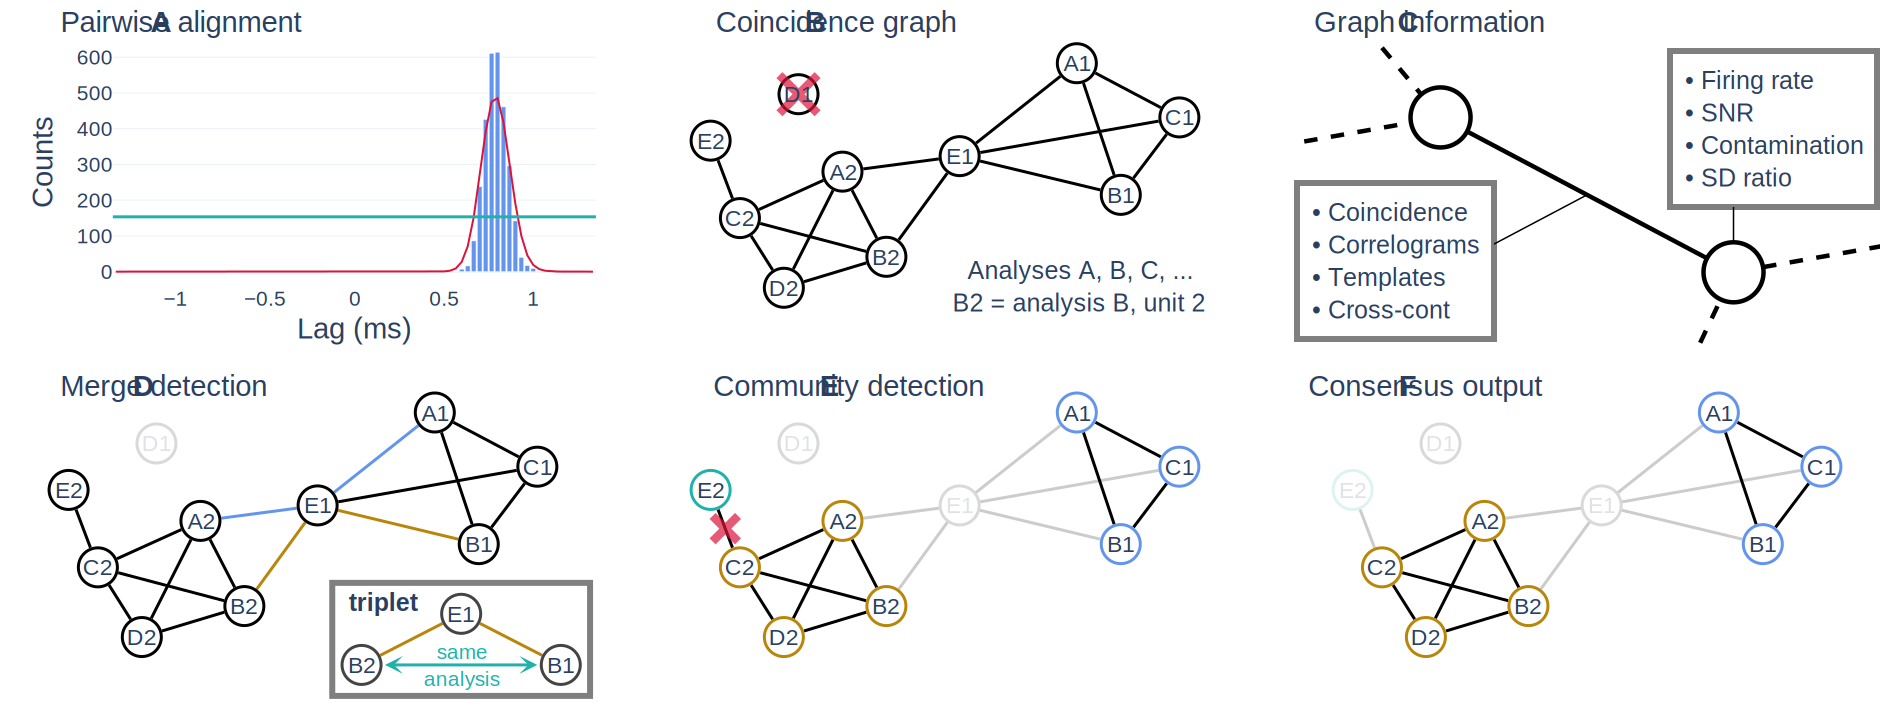

In [5]:
graph = nx.Graph()
for i in range(3):
    analysis1 = chr(65+i)
    for j in range(i+1, 4):
        analysis2 = chr(65+j)
        if j != 3:
            graph.add_edge(f"{analysis1}1", f"{analysis2}1")
        graph.add_edge(f"{analysis1}2", f"{analysis2}2")
    graph.add_edge(f"{analysis1}1", "E1")
    if i != 2:
        graph.add_edge(f"{analysis1}2", "E1")
graph.add_node("D1")
graph.add_edge("C2", "E2")

for node in graph.nodes:
    graph.nodes[node]['removed'] = False
    graph.nodes[node]['color'] = "Black"
# for node1, node2 in graph.edges:
#     graph[node1][node2]['removed'] = False

pos = {
    'A1': [0.45, 0.85],
    'B1': [0.6, -0],
    'C1': [0.8, 0.5],
    'D1': [-0.5, 0.65],
    'E1': [0.05, 0.25],
    'A2': [-0.35, 0.15],
    'B2': [-0.2, -0.4],
    'C2': [-0.7, -0.15],
    'D2': [-0.55, -0.6],
    'E2': [-0.8, 0.35]
}

width, height = get_dimensions(max_width_2c, 6.0)
edge_style = dict(width=0.01*ppi, color="Black")
alpha_deleted = 0.15
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'showlegend': False,
    'margin': dict(l=10, r=10, t=10+0.1*ppi, b=10),
    'font_family': "helvetica"
}
spacing_x = 0.03
spacing_y = 0.06
domain_width = (1 - 2*spacing_x) / 3
domain_height = (1 - spacing_y) / 2
for i in range(3):
    start = i * (domain_width + spacing_x)
    layout[f'xaxis{i+1}'] = dict(anchor="y1", range=[-1, 1], domain=[start, start+domain_width], showgrid=False,
                                 zeroline=False, showticklabels=False)
layout['xaxis4'] = dict(anchor="y3", title_text="Lag (ms)", title_standoff = 0.03*ppi,
                        domain=[0.055, domain_width], **axis_format)
for i in range(2):
    start = i * (domain_height + spacing_y)
    layout[f'yaxis{i+1}'] = dict(anchor="x1", range=[-1, 1], domain=[start, start+domain_height], showgrid=False,
                                 zeroline=False, showticklabels=False)
layout['yaxis3'] = dict(anchor="x4", title_text="Counts", domain=[domain_height+spacing_y+0.1, 2*domain_height+spacing_y],
                        **axis_format)

fig = go.Figure()
fig.update_layout(**layout)

def plot_nodes(xaxis: str, yaxis: str) -> None:
    colors = [graph.nodes[node]['color'] for node in pos.keys()]
    opacity = [alpha_deleted if graph.nodes[node]['removed'] else 1.0 for node in pos.keys()]
        
    fig.add_trace(go.Scatter(  # White first to remove lines.
        xaxis=xaxis, yaxis=yaxis,
        x=np.array(list(pos.values()))[:, 0],
        y=np.array(list(pos.values()))[:, 1],
        mode="markers",
        marker=dict(color="White", size=0.14*ppi)
    ))
    fig.add_trace(go.Scatter(
        xaxis=xaxis, yaxis=yaxis,
        x=np.array(list(pos.values()))[:, 0],
        y=np.array(list(pos.values()))[:, 1],
        mode="markers",
        marker=dict(color="White", size=0.13*ppi, opacity=opacity, line=dict(color=colors, width=0.01*ppi))
    ))
    
    for i, node in enumerate(pos.keys()):
        fig.add_annotation(text=node, xref=xaxis, yref=yaxis, x=pos[node][0], y=pos[node][1], showarrow=False,
                           font_size=5.5*px_per_point, opacity=opacity[i])

# Panel A
max_shift = 40
sorting2 = se.PhySortingExtractor(injection_folder / "analyses" / "ks2_CS")
spike_train1 = sorting.get_unit_spike_train(56)
spike_train2 = sorting2.get_unit_spike_train(6)
threshold = 0.05 * min(len(spike_train1), len(spike_train2))
cross_corr = spost.correlograms._compute_crosscorr_numba(spike_train1, spike_train2, max_shift+1, 1)[1:]
std = 1.5
N = math.ceil(5 * std)
gaussian = np.exp(-np.arange(-N, N+1)**2 / (2 * std**2)) / (std * math.sqrt(2*math.pi))
filtered_cross_corr = np.convolve(cross_corr, gaussian, mode="same")
fig.add_hline(xref="x4", yref="y3", y=threshold, line=dict(width=0.01*ppi, color="LightSeaGreen"))
fig.add_trace(go.Bar(
    xaxis="x4", yaxis="y3",
    x=np.arange(-40, 41, 1) / 30,
    y=cross_corr,
    marker_color="CornflowerBlue"
))
fig.add_trace(go.Scatter(
    xaxis="x4", yaxis="y3",
    x=np.arange(-40, 41, 1) / 30,
    y=filtered_cross_corr,
    mode="lines",
    marker_color="Crimson"
))

# Panel B
fig.add_trace(go.Scatter(
    xaxis="x2", yaxis="y2",
    x=list(itertools.chain(*[[pos[node1][0], pos[node2][0], None] for node1, node2 in graph.edges])),
    y=list(itertools.chain(*[[pos[node1][1], pos[node2][1], None] for node1, node2 in graph.edges])),
    mode="lines",
    line=edge_style
))
plot_nodes("x2", "y2")
fig.add_trace(go.Scatter(
    xaxis="x2", yaxis="y2",
    x=[pos['D1'][0]],
    y=[pos['D1'][1]],
    mode="markers",
    marker=dict(symbol="x-thin", opacity=0.7, line=dict(color="Crimson", width=0.18*ppi))
))

fig.add_annotation(text="Analyses A, B, C, ...<br /> B2 = analysis B, unit 2", xref="x2", yref="y2", x=0.9, y=-0.8,
                   xanchor="right", yanchor="bottom", showarrow=False, font_size=6*px_per_point, align="center")

# Panel C
fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y2",
    x=[-0.5, 0.5],
    y=[0.5, -0.5],
    mode="lines",
    line=dict(width=0.015*ppi, color="Black")
))
fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y2",
    x=[-0.7, -0.5, -1.1, None, 1.1, 0.5, 0.35],
    y=[0.95, 0.5, 0.3, None, -0.3, -0.5, -1.1],
    mode="lines",
    line=dict(width=0.015*ppi, color="Black", dash="dash")
))
fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y2",
    x=[0.5, 0.5],
    y=[-0.5, 0.5],
    mode="lines",
    line=dict(width=0.005*ppi, color="Black")
))
fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y2",
    x=[0, -0.5],
    y=[0, -0.5],
    mode="lines",
    line=dict(width=0.005*ppi, color="Black")
))
fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y2",
    x=[-0.5, 0.5],
    y=[0.5, -0.5],
    mode="markers",
    marker=dict(color="White", size=0.20*ppi, line=dict(color="Black", width=0.015*ppi))
))
fig.add_annotation(text="• Firing rate<br />• SNR<br />• Contamination<br />• SD ratio", xref="x3", yref="y2",
                   x=1.0, y=0.95, xanchor="right", yanchor="top", showarrow=False, font_size=6*px_per_point,
                   align="left", bordercolor="rgba(0, 0, 0, 0.5)", borderwidth=0.02*ppi, borderpad=0.04*ppi,
                   bgcolor="White")
fig.add_annotation(text="• Coincidence<br />• Correlograms<br />• Templates<br />• Cross-cont", xref="x3", yref="y2",
                   x=-1.0, y=-0.95, xanchor="left", yanchor="bottom", showarrow=False, font_size=6*px_per_point,
                   align="left", bordercolor="rgba(0, 0, 0, 0.5)", borderwidth=0.02*ppi, borderpad=0.04*ppi,
                   bgcolor="White")

# Panel D
graph.nodes["D1"]['removed'] = True
edges = [(node1, node2) for node1, node2 in graph.edges if node2 != "E1" or node1[0] == 'C']
fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=list(itertools.chain(*[[pos[node1][0], pos[node2][0], None] for node1, node2 in edges])),
    y=list(itertools.chain(*[[pos[node1][1], pos[node2][1], None] for node1, node2 in edges])),
    mode="lines",
    line=edge_style
))
for letter in ['A', 'B']:
    fig.add_trace(go.Scatter(
        xaxis="x1", yaxis="y1",
        x=[pos[f'{letter}1'][0], pos['E1'][0], pos[f'{letter}2'][0]],
        y=[pos[f'{letter}1'][1], pos['E1'][1], pos[f'{letter}2'][1]],
        mode="lines",
        line=dict(width=edge_style['width'], color="CornflowerBlue" if letter == "A" else "DarkGoldenRod")
    ))
plot_nodes("x1", "y1")

fig.add_shape(type="rect", xref="x1", yref="y1", x0=0.1, x1=0.98, y0=-0.98, y1=-0.25,
              line=dict(color="rgba(0, 0, 0, 0.5)", width=0.02*ppi))
fig.add_annotation(text="<b>triplet</b>", xref="x1", yref="y1", x=0.15, y=-0.27, xanchor="left", yanchor="top",
                   showarrow=False, font_size=6*px_per_point)

merged_pos = np.array([[0.2, -0.78], [0.54, -0.45], [0.88, -0.78]])
fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=merged_pos[:, 0],
    y=merged_pos[:, 1],
    mode="lines",
    line=edge_style,
    line_color="DarkGoldenRod"
))
fig.add_annotation(xref="x1", yref="y1", axref="x1", ayref="y1", x=0.28, y=merged_pos[0, 1], ax=0.81, ay=merged_pos[0, 1],
                   showarrow=True, arrowhead=3, arrowsize=1, arrowwidth=0.01*ppi, arrowside="end+start",
                   arrowcolor="LightSeaGreen")
fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=merged_pos[:, 0],
    y=merged_pos[:, 1],
    mode="markers",
    marker=dict(color="White", size=0.14*ppi)
))
fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=merged_pos[:, 0],
    y=merged_pos[:, 1],
    mode="markers",
    marker=dict(color="White", size=0.13*ppi, line_width=0.01*ppi)
))
fig.add_annotation(text="same<br />analysis", xref="x1", yref="y1", x=merged_pos[1, 0], y=merged_pos[0, 1],
                   font=dict(size=5*px_per_point, color="LightSeaGreen"), showarrow=False)

for node_pos, label in zip(merged_pos, ["B2", "E1", "B1"]):
    fig.add_annotation(text=label, xref="x1", yref="y1", x=node_pos[0], y=node_pos[1], showarrow=False,
                       font_size=5.5*px_per_point)

# Panel E
graph.nodes["E1"]['removed'] = True
graph.nodes["A1"]['color'] = "CornflowerBlue"
graph.nodes["B1"]['color'] = "CornflowerBlue"
graph.nodes["C1"]['color'] = "CornflowerBlue"
graph.nodes["A2"]['color'] = "DarkGoldenRod"
graph.nodes["B2"]['color'] = "DarkGoldenRod"
graph.nodes["C2"]['color'] = "DarkGoldenRod"
graph.nodes["D2"]['color'] = "DarkGoldenRod"
graph.nodes["E2"]['color'] = "LightSeaGreen"
for node1, node2 in graph.edges:
    fig.add_trace(go.Scatter(
        xaxis="x2", yaxis="y1",
        x=[pos[node1][0], pos[node2][0]],
        y=[pos[node1][1], pos[node2][1]],
        mode="lines",
        line=edge_style,
        line_color="rgba(0, 0, 0, 0.2)" if graph.nodes[node1]['removed'] or graph.nodes[node2]['removed'] else "Black"
    ))
plot_nodes("x2", "y1")
fig.add_trace(go.Scatter(
    xaxis="x2", yaxis="y1",
    x=[(pos['C2'][0] + pos['E2'][0]) / 2],
    y=[(pos['C2'][1] + pos['E2'][1]) / 2],
    mode="markers",
    marker=dict(symbol="x-thin", opacity=0.7, line=dict(color="Crimson", width=0.12*ppi))
))

# Panel F
graph.nodes["E2"]['removed'] = True
for node1, node2 in graph.edges:
    fig.add_trace(go.Scatter(
        xaxis="x3", yaxis="y1",
        x=[pos[node1][0], pos[node2][0]],
        y=[pos[node1][1], pos[node2][1]],
        mode="lines",
        line=edge_style,
        line_color="rgba(0, 0, 0, 0.2)" if graph.nodes[node1]['removed'] or graph.nodes[node2]['removed'] else "Black"
    ))
plot_nodes("x3", "y1")

labels = {
    'A': "Pairwise alignment",
    'B': "Coincidence graph",
    'C': "Graph information",
    'D': "Merge detection",
    'E': "Community detection",
    'F': "Consensus output"
}
for i, (key, label) in enumerate(labels.items()):
    fig.add_annotation(
        text=f"<b>{key}</b>    {label}",
        xref="paper",
        yref="paper",
        xanchor="left",
        x=0.00 + 0.35 * (i%3) - (0.03 if i%3==2 else 0),
        y=1.055 - 0.58 * (i//3),
        showarrow=False,
        font=dict(size=7*px_per_point)
    )

fig.show(renderer="svg")
pio.write_image(fig, "figs/merge_sortings.pdf", width=width, height=height, format="pdf", engine="kaleido")

## Synthetic dataset results

In [6]:
width, height = get_dimensions(max_width_2c, 13.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10+0.1*ppi, b=10),
    'font_family': "helvetica",
    'barmode': "relative",
    'legend': dict(font_size=5*px_per_point, orientation='h', yanchor="bottom", y=0.985, xanchor="right", x=0.28,
                   itemsizing="constant", bgcolor="rgba(0, 0, 0, 0.0)"),
    'legend2': dict(font_size=5*px_per_point, orientation='h', yanchor="top", y=1, xanchor="right", x=0.64,
                   itemsizing="constant"),
    'legend3': dict(font_size=5*px_per_point, yanchor="top", y=1, xanchor="left", x=0.725),
    'legend4': dict(font_size=6*px_per_point, grouptitlefont_size=7*px_per_point, orientation='h', yanchor="top",
                   y=-0.05, xanchor="left", x=0),
    'legend5': dict(font_size=6*px_per_point, orientation='h', yanchor="top", y=-0.07, xanchor="right", x=1),
    'xaxis1': dict(anchor="y1", title_text="Y axis (µm)", domain=[0, 0.28], **axis_format),
    'xaxis2': dict(anchor="y2", title_text="Distance to nearest electrode (µm)", domain=[0.36, 0.64], **axis_format),
    'xaxis3': dict(anchor="y3", title_text="Time (s)", domain=[0.72, 1], dtick=600, **axis_format),
    'xaxis4': dict(anchor="y8", domain=[0, 0.52], tickfont_size=6*px_per_point),
    'xaxis5': dict(anchor="y13", title_text="Minimum accuracy", range=[0.8, 1], domain=[0.62, 1], **axis_format),
    'yaxis1': dict(anchor="x1", title_text="Z axis (µm)", domain=[0.76, 1], **axis_format),
    'yaxis2': dict(anchor="x2", title_text="Max amplitude (µV)", domain=[0.76, 1], **axis_format),
    'yaxis3': dict(anchor="x3", title_text="Drift (µm)", domain=[0.76, 1], **axis_format),
    'yaxis4': dict(anchor="x4", title_text="Units", domain=[0.35, 0.65], **axis_format),
    'yaxis8': dict(anchor="x4", scaleanchor="y4", title_text="Units", domain=[0, 0.3], **axis_format),
    'yaxis12': dict(anchor="x5", domain=[0.35, 0.65], title_text="Number of neurons", **axis_format),
    'yaxis13': dict(anchor="x5", matches="y12", domain=[0, 0.3], title_text="Number of neurons", **axis_format)
}
for i in range(3):
    layout[f'yaxis{i+5}'] = dict(matches="y4", overlaying="y4", visible=False)
    layout[f'yaxis{i+9}'] = dict(matches="y8", overlaying="y8", visible=False)

fig = go.Figure()
fig.update_layout(**layout)

analyses_name = ["ks2_pj8-3", "ks2.5_pj7-3", "ks3_pj7-3", "ks4_low-thresh", "sc2_default", "tdc_default",
                 "lussac_heavy", "theoretical_maximum"]
analyses_formatted_name = ["Ks 2", "Ks 2.5", "Ks 3", "Ks 4", "SC 2", "Tdc", "Lussac", "Reference"]

# Panel A
gt_sorting = si.load_extractor("synthetic/analyses/ground_truth/sorting")
channel_pos = np.array(recording_generator_stationary.channel_positions)     # shape [n_channels, 3], µm
templates_pos = np.array(recording_generator_stationary.template_locations)  # shape [n_neurons, 3], µm
indices = np.arange(len(templates_pos))
np.random.shuffle(indices)                                                   # Shuffle indices for prettier plot
templates_pos = templates_pos[indices]
cell_types = recording_generator_stationary.template_celltypes[indices]
excitatory_mask = np.array([True if "pyr" in cell_type else False for cell_type in cell_types], dtype=bool)

fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=templates_pos[excitatory_mask, 1],
    y=templates_pos[excitatory_mask, 2],
    mode="markers",
    marker=dict(color="Crimson", size=0.01*ppi),
    name="Excitatory"
))
fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=templates_pos[~excitatory_mask, 1],
    y=templates_pos[~excitatory_mask, 2],
    mode="markers",
    marker=dict(color="Blue", size=0.01*ppi),
    name="Inhibitory"
))
fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=channel_pos[:, 1],
    y=channel_pos[:, 2],
    mode="markers",
    marker=dict(color="Green", size=0.02*ppi),
    name="Electrodes"
))

# Panel B
amplitudes = gt_sorting.get_property("max_amplitude")[indices]  # shape [n_neurons], µV
distance_to_nearest = np.min(np.sqrt(np.sum((templates_pos[:, None, :] - channel_pos[None, :, :]) ** 2, axis=2)), axis=1)

fig.add_trace(go.Scatter(
    xaxis="x2", yaxis="y2",
    x=distance_to_nearest[excitatory_mask],
    y=amplitudes[excitatory_mask],
    mode="markers",
    marker=dict(color="Crimson", size=0.01*ppi),
    name="Excitatory",
    legend="legend2"
))
fig.add_trace(go.Scatter(
    xaxis="x2", yaxis="y2",
    x=distance_to_nearest[~excitatory_mask],
    y=amplitudes[~excitatory_mask],
    mode="markers",
    marker=dict(color="Blue", size=0.01*ppi),
    name="Inhibitory",
    legend="legend2"
))

# Panel C
gt_recording = si.load_extractor("synthetic_drift/recording.bin")
dt = recording_generator_drifting.drift_list[0]['drift_fs'] * gt_recording.sampling_frequency * 1e-4
t_axis = np.arange(0, gt_recording.get_num_frames(), dt) / gt_recording.sampling_frequency
gt_drift = np.zeros(t_axis.shape, dtype=np.float32)
motion_info = spre.load_motion_info("synthetic_drift/motion_info")
for drift in recording_generator_drifting.drift_list:
    gt_drift += np.array(drift['drift_vector_um'])


fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y3",
    x=motion_info['temporal_bins'],
    y=np.median(motion_info['motion'], axis=1) - np.median(motion_info['motion'][0]),
    mode="lines",
    marker_color="Crimson",
    name="Recovered drift",
    legend="legend3",
    legendrank=2
))
fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y3",
    x=t_axis,
    y=gt_drift,
    mode="lines",
    marker_color="CornflowerBlue",
    name="Imposed drift",
    legend="legend3",
    legendrank=1
))

# Panels D-E-F-G
for row in range(2):
    folder = "synthetic" if row == 0 else "synthetic_drift"
    gt_sorting = si.load_extractor(f"{folder}/analyses/ground_truth/sorting")
    sortings = {name: si.load_extractor(f"{folder}/analyses/{name}/processed_sorting") for name in analyses_name}
    
    # Categorization
    results = {name: dict(zip(*np.unique(sortings[name].get_property('gt_label'), return_counts=True))) for name in analyses_name}
    keys = ["acc >= 95%", "95% > acc >= 80%", "80% > acc >= 50%", "50% > acc", "Split", "Redundant", "Merged", "MUA", "Noise"]
    for key in keys:
        for name in analyses_name:
            if key not in results[name]:
                results[name][key] = 0
    
    matched_df = pd.DataFrame(
        [[results[name]['acc >= 95%'], results[name]['95% > acc >= 80%'], -results[name]['80% > acc >= 50%'], -results[name]['50% > acc']] for name in analyses_name],
        index=analyses_name,
        columns=keys[:4]
    )
    split_df = pd.DataFrame(
        [[-results[name]['Split'], -results[name]['Redundant']] for name in analyses_name],
        index=analyses_name,
        columns=keys[4:6]
    )
    merged_df = pd.DataFrame(
        [[-results[name]['Merged']] for name in analyses_name],
        index=analyses_name,
        columns=['Merged']
    )
    noisy_df = pd.DataFrame(
        [[-results[name]['MUA'], -results[name]['Noise']] for name in analyses_name],
        index=analyses_name,
        columns=['MUA', 'Noise']
    )
    
    df = pd.concat([matched_df, split_df, merged_df, noisy_df], axis=1, keys=["Matched", "Under-aggregated", "Over-aggregated", "Garbage"])
    print(df)
    colors = {
        'Matched': {keys[0]: "#006400", keys[1]: "#228B22", keys[2]: "#90EE90", keys[3]: "#ACE3D2"},
        'Under-aggregated': {'Split': "#6495ED", 'Redundant': "#008B8B"},
        'Over-aggregated': {'Merged': "#DC143C"},
        'Garbage': {'MUA': "#BA55D3", 'Noise': "#000000"}
    }
    
    w = 0.18
    for i, t in enumerate(colors):
        for col in df[t].columns:
            if col == keys[0]:
                col_legend = "95% -- 100%"
                t_legend = "Well Matched"
            elif col == keys[1]:
                col_legend = "80% -- 95%"
                t_legend = "Well Matched"
            elif col == keys[2]:
                col_legend = "50% -- 80%"
                t_legend = "Poorly Matched"
            elif col == keys[3]:
                col_legend = "0% -- 50%"
                t_legend = "Poorly Matched"
            else:
                col_legend = col
                t_legend = t
            fig.add_trace(go.Bar(
                xaxis="x4", yaxis=f"y{4*row+i+4}",
                x=[name.replace('_', "<br />") for name in analyses_formatted_name],
                y=df[t][col],
                offsetgroup=str(i),
                offset=(i-1.5)*w,
                width=w,
                showlegend=(row==0),
                legend="legend4",
                legendgroup=t_legend,
                legendgrouptitle_text=t_legend,
                name=col_legend,
                marker_color=colors[t][col],
                hovertemplate="%{y}<extra></extra>"
            ))
            
    # Proportion by accuracy
    df = pd.DataFrame(0, index=gt_sorting.unit_ids, columns=analyses_name, dtype=np.float32)
    colors = {
        'theoretical_maximum': "Gray",
        'lussac_heavy': "CornflowerBlue",
        'ks2.5_pj7-3': "Crimson",
        'ks4_low-thresh': "DarkGoldenRod",
        'sc2_default': "Green"
    }
    
    for name, sorting in sortings.items():
        for unit_id in sorting.unit_ids:
            neuron_id = sorting.get_unit_property(unit_id, "gt_neuron")
            if neuron_id == "":
                continue
            accuracy = sorting.get_unit_property(unit_id, 'gt_accuracy')
            df.loc[neuron_id, name] = max(df[name][neuron_id], accuracy)
    
    dx = 0.0001
    xaxis = np.arange(0.8, 1+dx/2, dx)
    for i, name in enumerate(analyses_name):
        if name not in ["theoretical_maximum", "lussac_heavy", "ks2.5_pj7-3", "ks4_low-thresh", "sc2_default"]:
            continue
            
        fig.add_trace(go.Scatter(
            xaxis="x5", yaxis=f"y{12+row}",
            x=xaxis,
            y=np.sum(df[name].to_numpy()[:, None] >= xaxis[None, :], axis=0),
            mode="lines",
            name=analyses_formatted_name[i].replace('_', ' '),
            marker_color=colors[name],
            showlegend=(row==0),
            legend="legend5",
            legendgroup=f"scatter_{name}"
        ))
        
for i in range(3):
    fig.add_annotation(
        text=f"<b>{chr(65+i)}</b>",
        xref=f"x{'' if i==0 else i+1} domain",
        yref=f"y{'' if i==0 else i+1} domain",
        xanchor="left",
        yanchor="bottom",
        x=-0.175,
        y=1.02,
        showarrow=False,
        font=dict(size=7*px_per_point)
    )
for i in range(4):
    fig.add_annotation(
        text=f"<b>{chr(68+i)}</b>",
        xref="paper",
        yref=f"y{12 + i//2} domain",
        xanchor="left",
        yanchor="bottom",
        x=-0.045 + 0.618*(i%2),
        y=1.03,
        showarrow=False,
        font=dict(size=7*px_per_point)
    )
    fig.add_annotation(
        text=f"{'Stationary' if i//2==0 else 'Drifting'}",
        xref=f"x{4 + (i%2)} domain",
        yref=f"y{12 + i//2} domain",
        xanchor="right",
        yanchor="top",
        x=0.965,
        y=1.0,
        showarrow=False,
        font=dict(size=6*px_per_point),
        bgcolor="White"
    )
            

fig.show(renderer="svg")
pio.write_image(fig, "figs/benchmark_synthetic.pdf", width=width, height=height, format="pdf", engine="kaleido")

                       Matched                                              \
                    acc >= 95% 95% > acc >= 80% 80% > acc >= 50% 50% > acc   
ks2_pj8-3                  233               56              -34       -20   
ks2.5_pj7-3                235               87              -38       -35   
ks3_pj7-3                  119               66              -15        -2   
ks4_low-thresh             178               75              -15        -6   
sc2_default                171               22              -18       -11   
tdc_default                 39               41               -9         0   
lussac_heavy               249               73              -30       -13   
theoretical_maximum        251               77              -37       -26   

                    Under-aggregated           Over-aggregated Garbage        
                               Split Redundant          Merged     MUA Noise  
ks2_pj8-3                         -8        -7             -1

ValueError: spikeinterface.Base.load() file_path must be an existing folder or file

## Injection dataset results

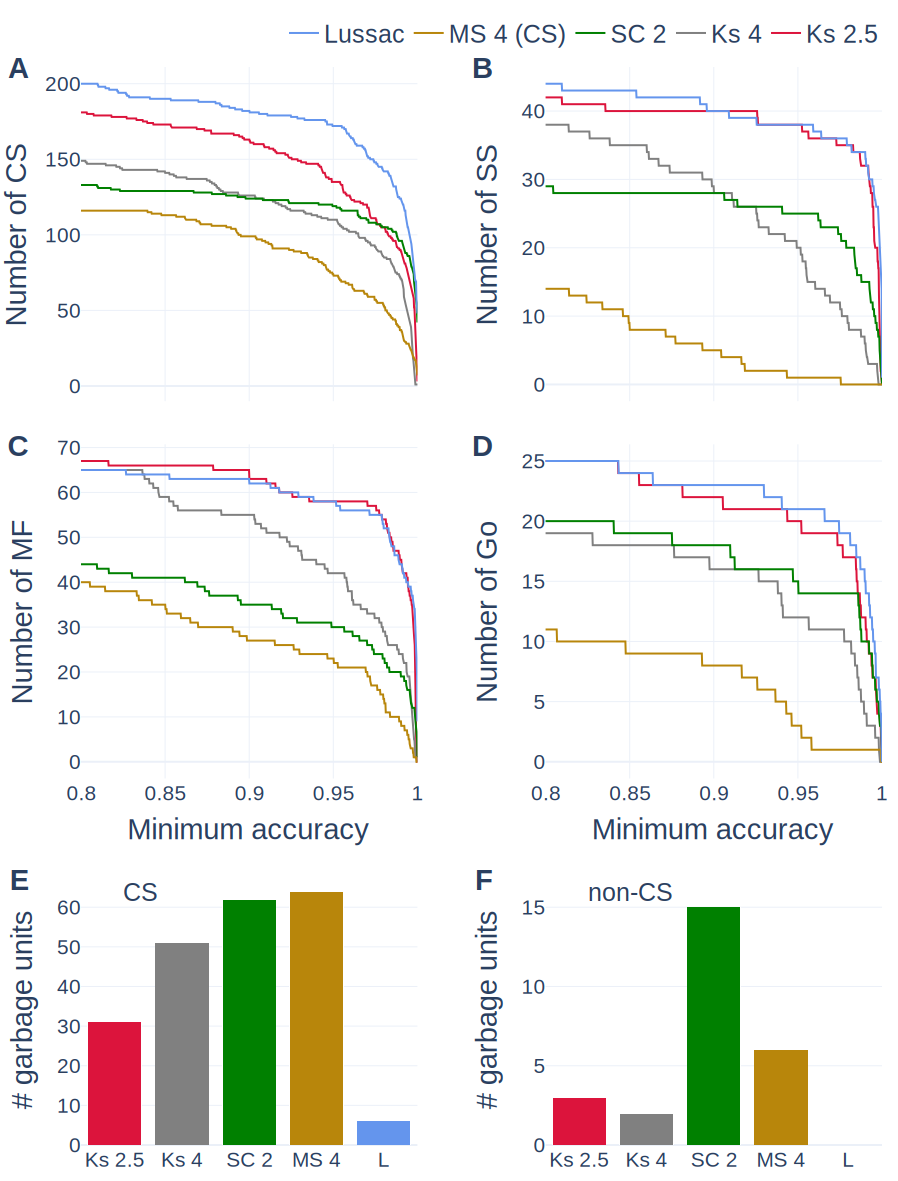

In [7]:
with open("injection/analyzed_df.pkl", 'rb') as file:
    all_df = pickle.load(file)
with open("injection/garbage_units.pkl", 'rb') as file:
    garbage_units = pickle.load(file)

width, height = get_dimensions(max_width_1c, 10.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'barmode': "stack",
    'legend': dict(font_size=6*px_per_point, orientation='h', yanchor="bottom", y=1.01, xanchor="right", x=1),
    'xaxis1': dict(anchor="y3", domain=[0, 0.42], title_text="Minimum accuracy", **axis_format),
    'xaxis2': dict(anchor="y4", domain=[0.58, 1], title_text="Minimum accuracy", **axis_format),
    'xaxis3': dict(anchor="y5", domain=[0, 0.42], **axis_format),
    'xaxis4': dict(anchor="y6", domain=[0.58, 1], **axis_format),
    'yaxis1': dict(anchor="x1", domain=[0.69, 1], **axis_format),
    'yaxis2': dict(anchor="x2", domain=[0.69, 1], **axis_format),
    'yaxis3': dict(anchor="x1", domain=[0.34, 0.65], **axis_format),
    'yaxis4': dict(anchor="x2", domain=[0.34, 0.65], **axis_format),
    'yaxis5': dict(anchor="x3", domain=[0, 0.25], title_text="# garbage units", range=[0, 68], **axis_format),
    'yaxis6': dict(anchor="x4", domain=[0, 0.25], title_text="# garbage units", range=[0, 17], **axis_format)
}

fig = go.Figure()

xaxis = np.linspace(0.8, 1.0, 1000)
analyses_color = {
    'ks2.5_optimized': "Crimson",
    'ks4_default': "Grey",
    'sc2_default': "Green",
    'ms4_CS': "DarkGoldenRod",
    'lussac': "CornflowerBlue"
}
names = {
    'ks2.5_optimized': "Ks 2.5",
    'ks4_default': "Ks 4",
    'sc2_default': "SC 2",
    'ms4_CS': "MS 4 (CS)",
    'lussac': "Lussac"
}
short_names = {
    'ks2.5_optimized': "Ks 2.5",
    'ks4_default': "Ks 4",
    'sc2_default': "SC 2",
    'ms4_CS': "MS 4",
    'lussac': "L"
}

for i, cell_type in enumerate(["CS", "SS", "MF", "Go"]):
    df = all_df[all_df['type'] == cell_type]
    layout[f'yaxis{i+1}']['title_text'] = f"Number of {cell_type}"
    
    for analysis_name in analyses_color.keys():
        fig.add_trace(go.Scatter(
            xaxis=f"x{1+i%2}",
            yaxis=f"y{i+1}",
            x=xaxis,
            y=np.sum(df[analysis_name].to_numpy()[:, None] >= xaxis[None, :], axis=0),
            mode="lines",
            name=names[analysis_name],
            marker_color=analyses_color[analysis_name],
            showlegend=(i == 0)
        ))

fig.add_trace(go.Bar(
    xaxis="x3",
    yaxis="y5",
    x=list(short_names.values()),
    y=[garbage_units[name]['CS'] for name in names.keys()],
    marker_color=[analyses_color[name] for name in names.keys()],
    showlegend=False
))
fig.add_trace(go.Bar(
    xaxis="x4",
    yaxis="y6",
    x=list(short_names.values()),
    y=[(sum(garbage_units[name].values()) - garbage_units[name]['CS']) for name in names.keys()],
    marker_color=[analyses_color[name] for name in names.keys()],
    showlegend=False
))
#         ection/{template_info['mouse_ID']}/recording.bin")
#     recording_f = spre.gaussian_filter(
fig.update_layout(**layout)
for i in range(6):
    fig.add_annotation(
        text=f"<b>{chr(65+i)}</b>",
        xref=f"x{'2' if i%2 == 1 else ''} domain",
        yref=f"y{i+1 if i>0 else ''} domain",
        xanchor="right",
        yanchor="top",
        x=-0.15,
        y=1.05,
        showarrow=False,
        font=dict(size=7*px_per_point)
    )

for i in range(2):
    fig.add_annotation(
        text="CS" if i==0 else "non-CS",
        xref=f"x{3+i} domain",
        yref="y5 domain",
        xanchor="left",
        yanchor="top",
        x=0.12,
        y=1.0,
        showarrow=False,
        font=dict(size=6*px_per_point)
    )
    
fig.show(renderer="svg")
pio.write_image(fig, "figs/benchmark_injection.pdf", width=width, height=height, format="pdf", engine="kaleido")

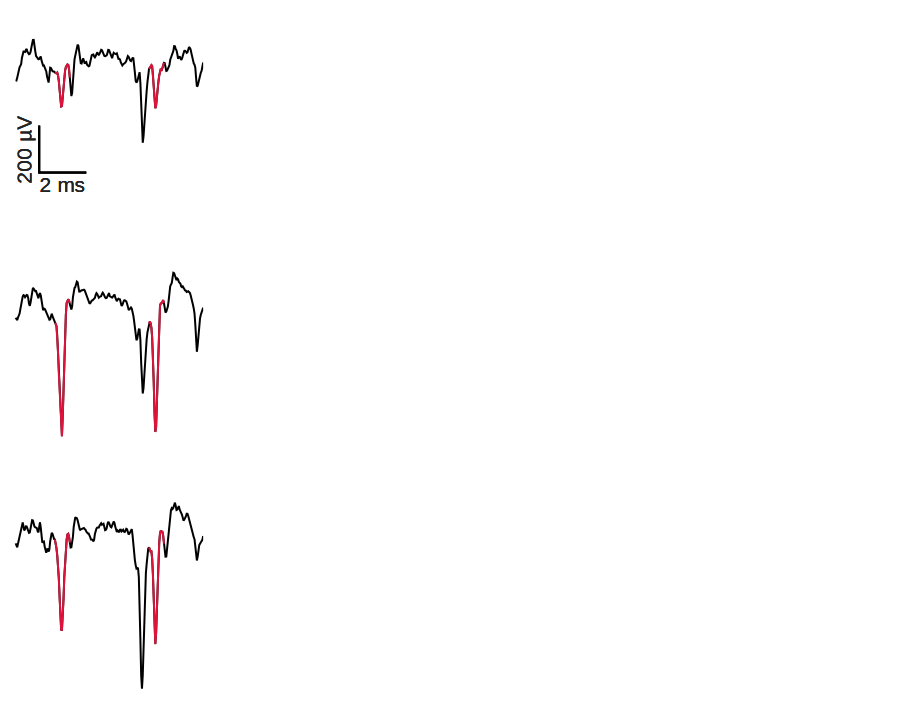

In [8]:
width, height = get_dimensions(max_width_1c, 6.0)
layout = {
    'width': width,
    'height': height,
    'template': "simple_white",
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'showlegend': False
}

for i in range(4):
    layout[f'xaxis{i+1}'] = dict(anchor=f"y{2*i+3}", domain=[0.26*i, 0.26*i+0.22])
    
    if i%2 == 0:
        layout[f'yaxis{2*i+1}'] = dict(anchor=f"x{i+1}", domain=[0.7, 1])
        layout[f'yaxis{2*i+2}'] = dict(anchor=f"x{i+1}", scaleanchor=f"y{2*i+1}", domain=[0.35, 0.65])
        layout[f'yaxis{2*i+3}'] = dict(anchor=f"x{i+1}", scaleanchor=f"y{2*i+1}", domain=[0, 0.3])

templates = pickle.load(open("injection/gt_templates.pkl", 'rb'))
template_id = 70
template_info = templates[template_id]

injected_sorting = si.load_extractor("injection/0171/injection/gt_sorting")
assert template_id in injected_sorting.get_property("template_id")

with warnings.catch_warnings():  # Silence "not same version" warning.
    warnings.simplefilter("ignore")
    recording_inj = si.load_extractor(f"injection/{template_info['mouse_ID']}/recording.bin")
    recording_inj_f = spre.gaussian_filter(recording_inj, freq_min=150, freq_max=8000)
best_channel_index = np.argmax(np.max(np.abs(template_info['template']), axis=0))
channel_ids = recording_inj.channel_ids[best_channel_index-1:best_channel_index+2]
t = template_info['spike_train'][np.argmax(np.diff(template_info['spike_train']) == 120)]

traces = recording_inj_f.get_traces(start_frame=t-60, end_frame=t+180, channel_ids=channel_ids, return_scaled=True)

fig = go.Figure()
fig.update_layout(**layout)
fig.update_xaxes(showticklabels=False, zeroline=False, visible=False)
fig.update_yaxes(showticklabels=False, zeroline=False, visible=False)

for i in range(3):
    fig.add_trace(go.Scatter(
        xaxis="x1", yaxis=f"y{i+1}",
        y=traces[:, i],
        mode="lines",
        marker_color="Black"
    ))
    fig.add_trace(go.Scatter(
        xaxis="x1", yaxis=f"y{i+1}",
        x=np.arange(50, 70),
        y=traces[50:70, i],
        mode="lines",
        marker_color="Crimson"
    ))
    fig.add_trace(go.Scatter(
        xaxis="x1", yaxis=f"y{i+1}",
        x=np.arange(170, 190),
        y=traces[170:190, i],
        mode="lines",
        marker_color="Crimson"
    ))

    fig.add_trace(go.Scatter(
        xaxis="x1", yaxis="y1",
        x=[30, 30, 90],
        y=[-250, -450, -450],
        mode="lines",
        marker_color="Black"
    ))
    fig.add_annotation(text="2 ms", xref="x1", yref="y1", x=60, y=-500, showarrow=False, font_size=5*px_per_point)
    fig.add_annotation(text="200 µV", xref="x1", yref="y1", x=10, y=-350, textangle=-90, showarrow=False, font_size=5*px_per_point)

fig.show(renderer="svg")
pio.write_image(fig, "figs/injection_methods.pdf", width=width, height=height, format="pdf", engine="kaleido")

## Purkinje cells

/users/nsr/wyngaard/dev/miniconda3/envs/benchmark_lussac/lib/python3.11/site-packages/spikeinterface/core/base.py:1089: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.0.dev0 is recommended



estimate_templates_with_accumulator:   0%|          | 0/1852 [00:00<?, ?it/s]

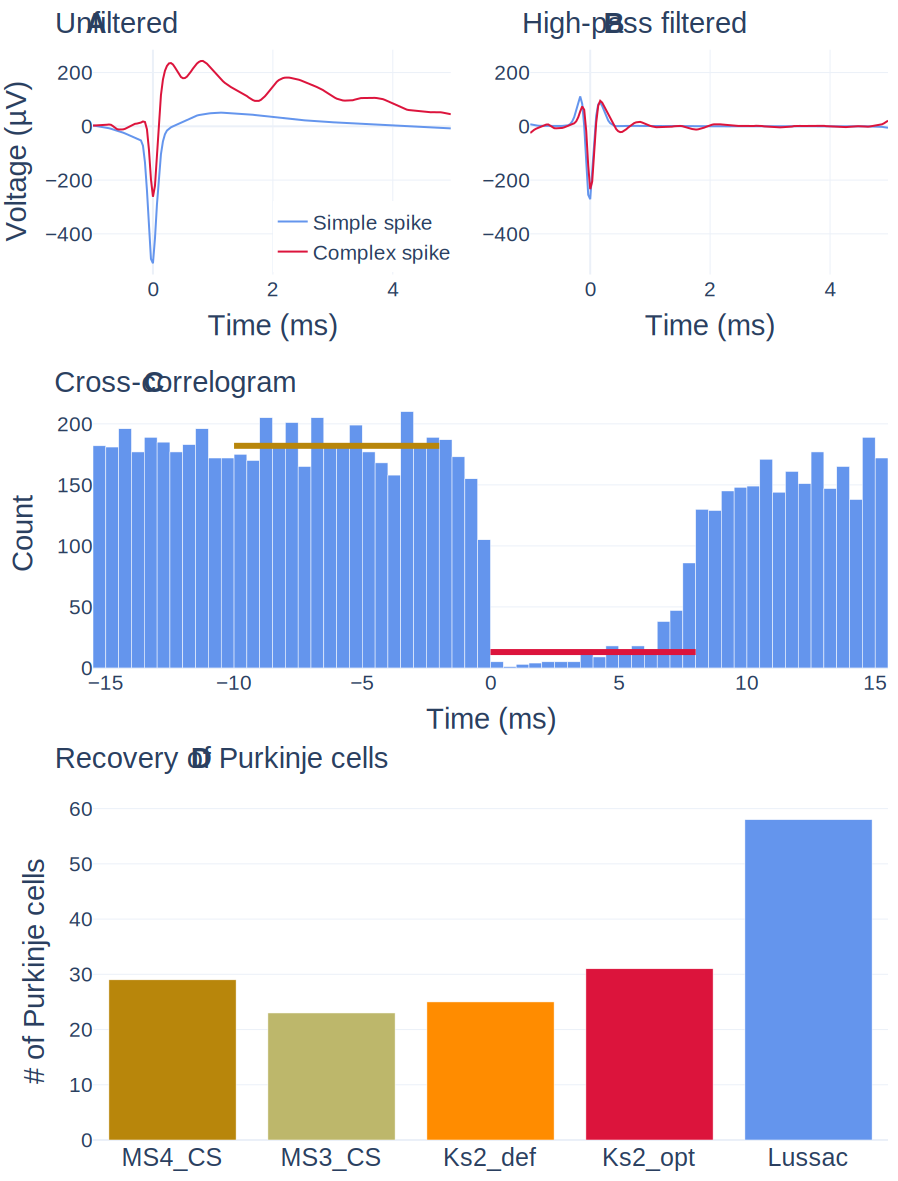

In [9]:
SS_id = 78
CS_id = 56
ms_before = 1.0
ms_after = 5.0

# Extract unfiltered templates and correlograms
sorting = si.load_extractor(injection_folder / "analyses" / "sc_optimized" / "in_container_sorting")
sorting_analyzer = si.create_sorting_analyzer(spost.align_sorting(sorting.select_units([SS_id, CS_id]), {SS_id: -1, CS_id: 6}),
                                              recording.select_channels([50]),
                                              sparse=False, return_scaled=True)
sorting_analyzer.compute({
    'random_spikes': dict(max_spikes_per_unit=20_000),
    'templates': dict(ms_before=ms_before, ms_after=ms_after),
    'correlograms': dict(window_ms=31.0, bin_ms=0.5)
})

templates = sorting_analyzer.get_extension("templates").get_data()[:, :, 0]
SS_template = templates[0]
CS_template = templates[1]
SS_template_filtered = utils.filter(SS_template, band=[1_500, 15_000])[0]
CS_template_filtered = utils.filter(CS_template, band=[1_500, 15_000])[0]

correlograms, bins = sorting_analyzer.get_extension("correlograms").get_data()
bin_size = bins[1] - bins[0]
bins = bins[:-1]
baseline = np.median(correlograms[0, 1, (bins > -10) & (bins < -2)])
value = np.median(correlograms[0, 1, (bins > 0) & (bins < 8)])

width, height = get_dimensions(max_width_1c, 10.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'legend': dict(font_size=5*px_per_point, yanchor="top", y=0.835, xanchor="right", x=0.455),
    'xaxis1': dict(anchor="y1", title_text="Time (ms)", domain=[0, 0.45], **axis_format),
    'yaxis1': dict(anchor="x1", title_text="Voltage (µV)", domain=[0.77, 0.97], **axis_format),
    'xaxis2': dict(anchor="y2", title_text="Time (ms)", domain=[0.55, 1], **axis_format),
    'yaxis2': dict(anchor="x2", domain=[0.77, 0.97], matches="y1", **axis_format),
    'xaxis3': dict(anchor="y3", title_text="Time (ms)", **axis_format),
    'yaxis3': dict(anchor="x3", title_text="Count", domain=[0.42, 0.66], **axis_format),
    'xaxis4': dict(anchor="y4", tickfont_size=6*px_per_point),
    'yaxis4': dict(anchor="x4", domain=[0, 0.3], title_text="# of Purkinje cells", **axis_format)
}

# The data will be made available as part of Llobet et al (in preparation) or if requested.
# n_CS = dict(Kilosort=105, lussac=214)
n_pairs = dict(MS4_CS=29, MS3_CS=23, Ks2_def=25, Ks2_opt=31, Lussac=58)
analyses_color = {
    'lussac': "CornflowerBlue",
    'ks2_CS': "BlueViolet",
    'ks2_SS': "DarkOrange",
    'ks2.5_optimized': "Crimson",
    'ks3_default': "LightSeaGreen",
    'ks4_default': "Grey",
    'sc2_default': "Green",
    'ms3_CS': "DarkKhaki",
    'ms4_CS': "DarkGoldenRod"
}

fig = go.Figure()
fig.update_layout(**layout)

fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=np.arange(-ms_before, ms_after, 1/30),
    y=SS_template,
    mode="lines",
    marker_color="CornflowerBlue",
    name="Simple spike"
))
fig.add_trace(go.Scatter(
    xaxis="x1", yaxis="y1",
    x=np.arange(-ms_before, ms_after, 1/30),
    y=CS_template,
    mode="lines",
    marker_color="Crimson",
    name="Complex spike"
))
fig.add_trace(go.Scatter(
    xaxis="x2", yaxis="y2",
    x=np.arange(-ms_before, ms_after, 1/30),
    y=SS_template_filtered,
    mode="lines",
    marker_color="CornflowerBlue",
    showlegend=False
))
fig.add_trace(go.Scatter(
    xaxis="x2", yaxis="y2",
    x=np.arange(-ms_before, ms_after, 1/30),
    y=CS_template_filtered,
    mode="lines",
    marker_color="Crimson",
    showlegend=False
))

fig.add_trace(go.Bar(
    xaxis="x3", yaxis="y3",
    x=bins + bin_size/2,
    y=correlograms[0, 1],
    marker_color="CornflowerBlue",
    width=bin_size,
    showlegend=False
))
fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y3",
    x=[-10, -2],
    y=[baseline, baseline],
    mode="lines",
    marker_color="DarkGoldenRod",
    line_width=0.02*ppi,
    name="baseline",
    showlegend=False
))
fig.add_trace(go.Scatter(
    xaxis="x3", yaxis="y3",
    x=[0, 8],
    y=[value, value],
    mode="lines",
    marker_color="Crimson",
    line_width=0.02*ppi,
    showlegend=False
))

fig.add_trace(go.Bar(
    xaxis="x4", yaxis="y4",
    x=list(n_pairs.keys()),
    y=list(n_pairs.values()),
    marker_color=["DarkGoldenRod", "DarkKhaki", "DarkOrange", "Crimson", "CornflowerBlue"],
    showlegend=False
))

additional_text = ["Unfiltered", "High-pass filtered", "Cross-correlogram", "Recovery of Purkinje cells"]
for i in range(4):
    fig.add_annotation(
        text=f"<b>{chr(65+i)}</b> {additional_text[i]}",
        xref="paper",
        yref="paper",
        x=-0.095 + (0.75 if i == 1 else 0),
        y=1.01 if i<2 else 0.69 if i==2 else 0.34,
        showarrow=False,
        font=dict(size=7*px_per_point)
    )

fig.show(renderer="svg")
pio.write_image(fig, "figs/purkinje_cells.pdf", width=width, height=height, format="pdf", engine="kaleido")

## Supp: Synthetic results

In [10]:
width, height = get_dimensions(max_width_2c, 13.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10+0.1*ppi, b=10),
    'font_family': "helvetica",
    'barmode': "relative",
    'legend': dict(font_size=5*px_per_point, orientation='h', yanchor="bottom", y=0.985, xanchor="right", x=0.28,
                   itemsizing="constant", bgcolor="rgba(0, 0, 0, 0.0)"),
    'legend2': dict(font_size=5*px_per_point, orientation='h', yanchor="top", y=1, xanchor="right", x=0.64,
                   itemsizing="constant"),
    'legend3': dict(font_size=5*px_per_point, yanchor="top", y=1, xanchor="left", x=0.725),
    'legend4': dict(font_size=6*px_per_point, grouptitlefont_size=7*px_per_point, orientation='h', yanchor="top",
                   y=-0.05, xanchor="left", x=0),
    'legend5': dict(font_size=6*px_per_point, orientation='h', yanchor="top", y=-0.07, xanchor="right", x=1),
    'xaxis1': dict(anchor="y5", domain=[0, 1], tickfont_size=6*px_per_point),
    'xaxis2': dict(anchor="y9", title_text="Minimum accuracy", range=[0.7, 1], domain=[0, 0.47], **axis_format),
    'xaxis3': dict(anchor="y10", title_text="Minimum accuracy", range=[0.7, 1], domain=[0.53, 1], **axis_format),
    'yaxis1': dict(anchor="x1", domain=[0.7, 1], **axis_format),
    'yaxis5': dict(anchor="x1", scaleanchor="y1", domain=[0.37, 0.67], **axis_format),
    'yaxis9': dict(anchor="x2", domain=[0, 0.28], title_text="Number of neurons", **axis_format),
    'yaxis10': dict(anchor="x3", matches="y9", domain=[0, 0.28], **axis_format)
}
for i in range(3):
    layout[f'yaxis{i+2}'] = dict(matches="y1", overlaying="y1", visible=False)
    layout[f'yaxis{i+6}'] = dict(matches="y5", overlaying="y5", visible=False)

fig = go.Figure()
fig.update_layout(**layout)

analyses_name = ["ks2_default", "ks2_pj8-3", "ks2.5_default", "ks2.5_pj7-3", "ks3_default", "ks3_pj7-3",
                 "ks4_default", "ks4_low-thresh", "sc_default", "sc2_default", "tdc_default",
                 "lussac_light", "lussac_heavy", "theoretical_maximum"]
analyses_formatted_name = ["Ks2 (def)", "Ks 2 (opt)", "Ks 2.5 (def)", "Ks 2.5 (opt)", "Ks 3 (def)", "Ks 3 (opt)",
                           "Ks 4 (def)", "Ks 4 (opt)", "SC 1 (def)", "SC 2 (def)", "Tdc (def)",
                           "Lussac light", "Lussac heavy", "Reference"]

for i, name in enumerate(analyses_formatted_name[:-1]):
    idx = name.rindex(' ')
    analyses_formatted_name[i] = f"{name[:idx]}<br />{name[idx+1:]}"

for row in range(2):
    folder = "synthetic" if row == 0 else "synthetic_drift"
    gt_sorting = si.load_extractor(f"{folder}/analyses/ground_truth/sorting")
    sortings = {name: si.load_extractor(f"{folder}/analyses/{name}/processed_sorting") for name in analyses_name}
    
    # Categorization
    results = {name: dict(zip(*np.unique(sortings[name].get_property('gt_label'), return_counts=True))) for name in analyses_name}
    keys = ["acc >= 95%", "95% > acc >= 80%", "80% > acc >= 50%", "50% > acc", "Split", "Redundant", "Merged", "MUA", "Noise"]
    for key in keys:
        for name in analyses_name:
            if key not in results[name]:
                results[name][key] = 0
    
    matched_df = pd.DataFrame(
        [[results[name]['acc >= 95%'], results[name]['95% > acc >= 80%'], -results[name]['80% > acc >= 50%'], -results[name]['50% > acc']] for name in analyses_name],
        index=analyses_name,
        columns=keys[:4]
    )
    split_df = pd.DataFrame(
        [[-results[name]['Split'], -results[name]['Redundant']] for name in analyses_name],
        index=analyses_name,
        columns=keys[4:6]
    )
    merged_df = pd.DataFrame(
        [[-results[name]['Merged']] for name in analyses_name],
        index=analyses_name,
        columns=['Merged']
    )
    noisy_df = pd.DataFrame(
        [[-results[name]['MUA'], -results[name]['Noise']] for name in analyses_name],
        index=analyses_name,
        columns=['MUA', 'Noise']
    )
    
    df = pd.concat([matched_df, split_df, merged_df, noisy_df], axis=1, keys=["Matched", "Under-aggregated", "Over-aggregated", "Garbage"])
    print(df)
    colors = {
        'Matched': {keys[0]: "#006400", keys[1]: "#228B22", keys[2]: "#90EE90", keys[3]: "#ACE3D2"},
        'Under-aggregated': {'Split': "#6495ED", 'Redundant': "#008B8B"},
        'Over-aggregated': {'Merged': "#DC143C"},
        'Garbage': {'MUA': "#BA55D3", 'Noise': "#000000"}
    }
    
    w = 0.18
    for i, t in enumerate(colors):
        for col in df[t].columns:
            if col == keys[0]:
                col_legend = "95% -- 100%"
                t_legend = "Well Matched"
            elif col == keys[1]:
                col_legend = "80% -- 95%"
                t_legend = "Well Matched"
            elif col == keys[2]:
                col_legend = "50% -- 80%"
                t_legend = "Poorly Matched"
            elif col == keys[3]:
                col_legend = "0% -- 50%"
                t_legend = "Poorly Matched"
            else:
                col_legend = col
                t_legend = t
            fig.add_trace(go.Bar(
                xaxis="x1", yaxis=f"y{4*row+i+1}",
                x=analyses_formatted_name,
                y=df[t][col],
                offsetgroup=str(i),
                offset=(i-1.5)*w,
                width=w,
                showlegend=(row==0),
                legend="legend4",
                legendgroup=t_legend,
                legendgrouptitle_text=t_legend,
                name=col_legend,
                marker_color=colors[t][col],
                hovertemplate="%{y}<extra></extra>"
            ))
            
    # Proportion by accuracy
    df = pd.DataFrame(0, index=gt_sorting.unit_ids, columns=analyses_name, dtype=np.float32)
    colors = {
        'theoretical_maximum': "Gray",
        'lussac_heavy': "CornflowerBlue",
        'lussac_light': "DeepSkyBlue",
        'ks2.5_pj7-3': "Crimson",
        'ks4_low-thresh': "DarkGoldenRod",
        'sc2_default': "Green"
    }
    
    for name, sorting in sortings.items():
        for unit_id in sorting.unit_ids:
            neuron_id = sorting.get_unit_property(unit_id, "gt_neuron")
            if neuron_id == "":
                continue
            accuracy = sorting.get_unit_property(unit_id, 'gt_accuracy')
            df.loc[neuron_id, name] = max(df[name][neuron_id], accuracy)
    
    dx = 0.0002
    xaxis = np.arange(0.7, 1+dx/2, dx)
    for i, name in enumerate(analyses_name):
        if name not in ["theoretical_maximum", "lussac_heavy", "lussac_light", "ks2.5_pj7-3",
                        "ks4_low-thresh", "sc2_default"]:
            continue
            
        fig.add_trace(go.Scatter(
            xaxis=f"x{2+row}", yaxis=f"y{9+row}",
            x=xaxis,
            y=np.sum(df[name].to_numpy()[:, None] >= xaxis[None, :], axis=0),
            mode="lines",
            name=analyses_formatted_name[i],
            marker_color=colors[name],
            showlegend=(row==0),
            legend="legend5",
            legendgroup=f"scatter_{name}"
        ))
        
for i in range(4):
    fig.add_annotation(
        text=f"<b>{chr(65+i)}</b>",
        xref="paper",
        yref=f"{'y' if i==0 else 'y5' if i==1 else 'y9'} domain",
        xanchor="left",
        yanchor="bottom",
        x=-0.045 + 0.555*(i//3),
        y=1.01,
        showarrow=False,
        font=dict(size=7*px_per_point)
    )

            

fig.show(renderer="svg")
pio.write_image(fig, "figs/benchmark_synthetic_supp.pdf", width=width, height=height, format="pdf", engine="kaleido")

                       Matched                                              \
                    acc >= 95% 95% > acc >= 80% 80% > acc >= 50% 50% > acc   
ks2_default                195               58              -23       -21   
ks2_pj8-3                  233               56              -34       -20   
ks2.5_default              185               74              -28       -17   
ks2.5_pj7-3                235               87              -38       -35   
ks3_default                117               59              -40       -27   
ks3_pj7-3                  119               66              -15        -2   
ks4_default                150               67              -43       -21   
ks4_low-thresh             178               75              -15        -6   
sc_default                 109               55              -47       -32   
sc2_default                171               22              -18       -11   
tdc_default                 39               41               -9

ValueError: spikeinterface.Base.load() file_path must be an existing folder or file

## Supp: Injection results

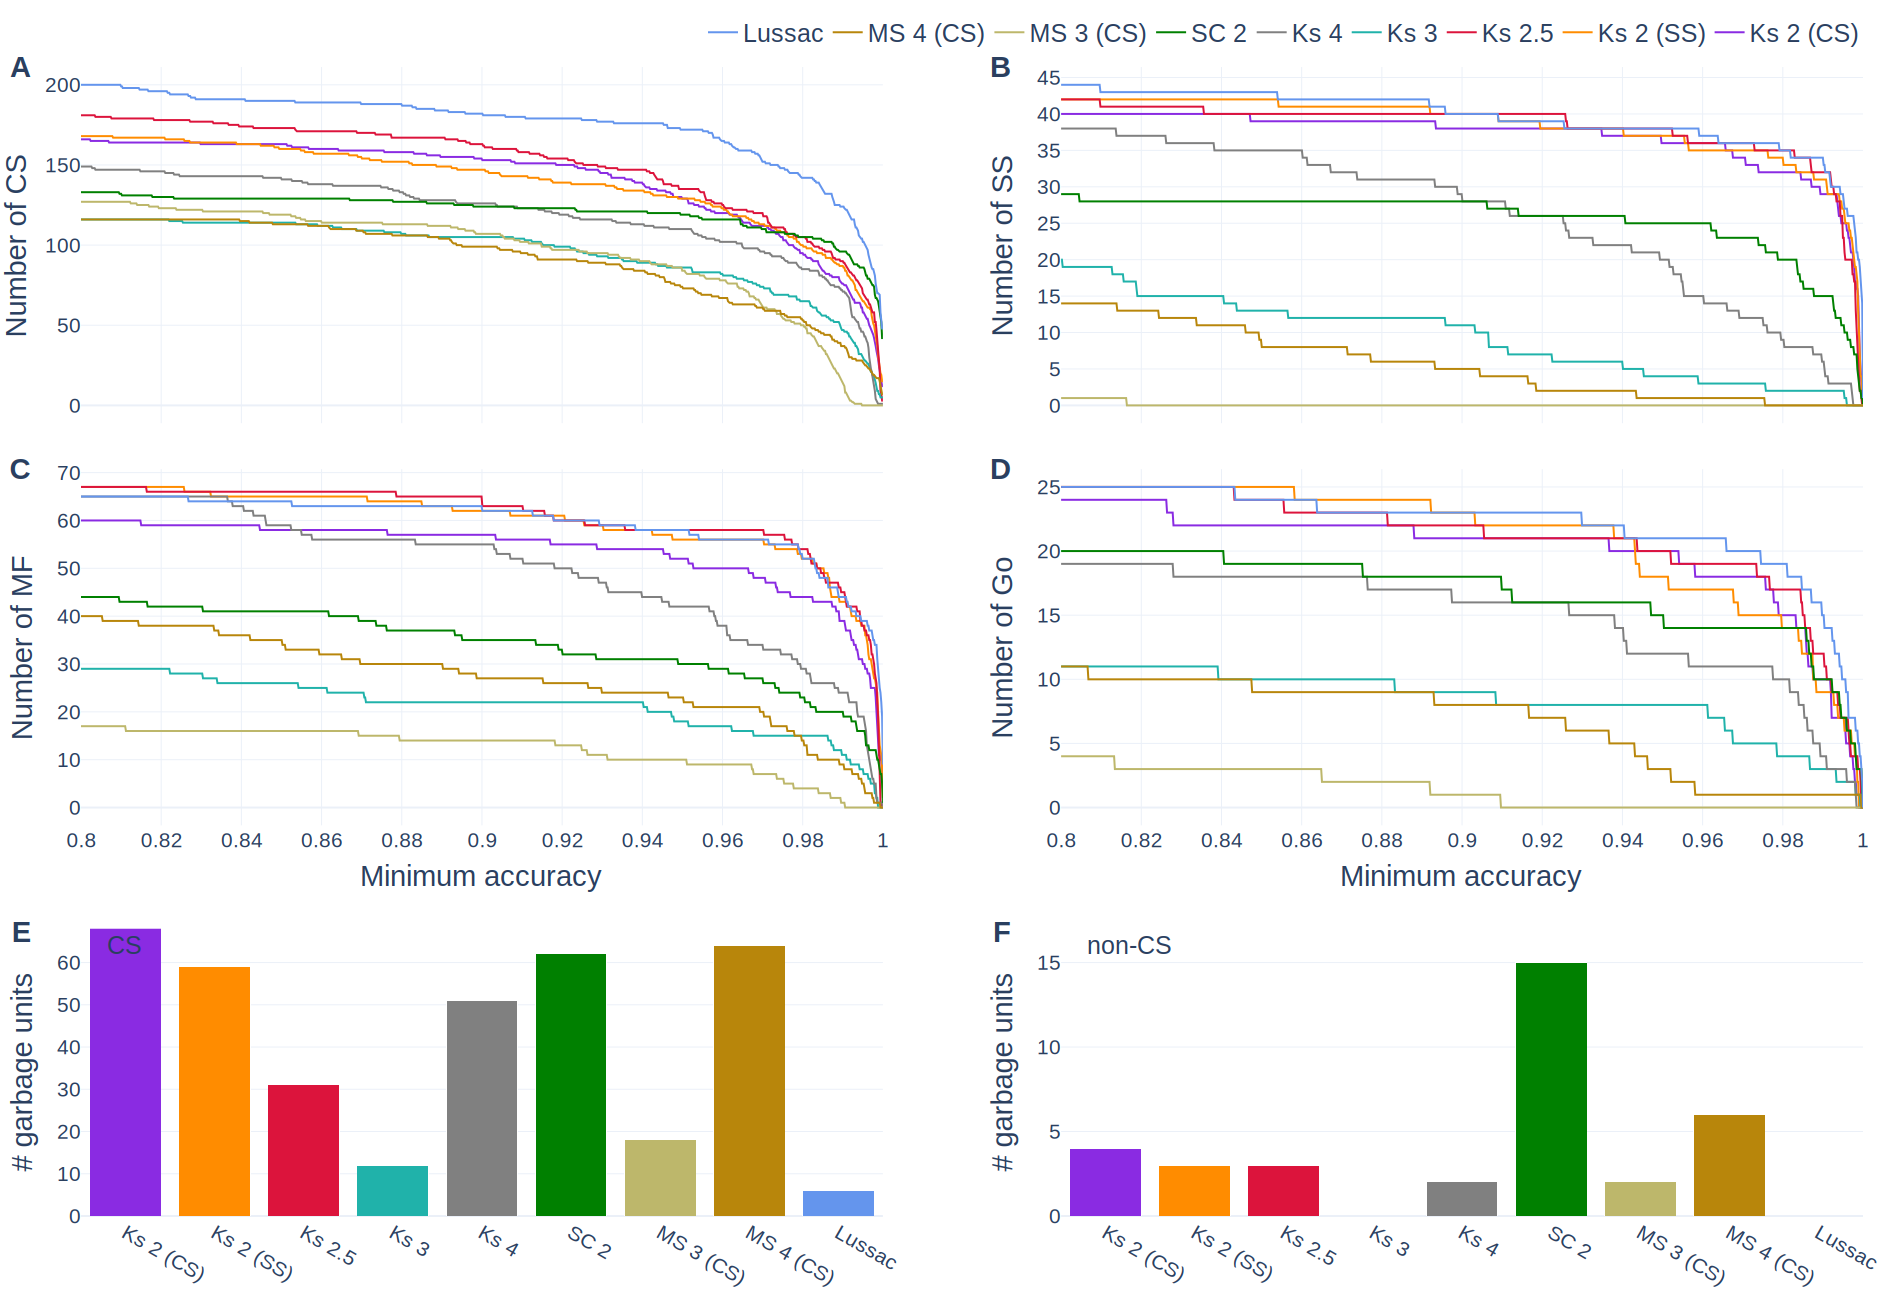

In [11]:
with open("injection/analyzed_df.pkl", 'rb') as file:
    all_df = pickle.load(file)
with open("injection/garbage_units.pkl", 'rb') as file:
    garbage_units = pickle.load(file)

width, height = get_dimensions(max_width_2c, 11.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'barmode': "stack",
    'legend': dict(font_size=6*px_per_point, orientation='h', yanchor="bottom", y=1.01, xanchor="right", x=1),
    'xaxis1': dict(anchor="y3", domain=[0, 0.45], title_text="Minimum accuracy", **axis_format),
    'xaxis2': dict(anchor="y4", domain=[0.55, 1], title_text="Minimum accuracy", **axis_format),
    'xaxis3': dict(anchor="y5", domain=[0, 0.45], **axis_format),
    'xaxis4': dict(anchor="y6", domain=[0.55, 1], **axis_format),
    'yaxis1': dict(anchor="x1", domain=[0.69, 1], **axis_format),
    'yaxis2': dict(anchor="x2", domain=[0.69, 1], **axis_format),
    'yaxis3': dict(anchor="x1", domain=[0.34, 0.65], **axis_format),
    'yaxis4': dict(anchor="x2", domain=[0.34, 0.65], **axis_format),
    'yaxis5': dict(anchor="x3", domain=[0, 0.25], title_text="# garbage units", range=[0, 68], **axis_format),
    'yaxis6': dict(anchor="x4", domain=[0, 0.25], title_text="# garbage units", range=[0, 17], **axis_format)
}

fig = go.Figure()

xaxis = np.linspace(0.8, 1.0, 1000)
analyses_color = {
    'ks2_CS': "BlueViolet",
    'ks2_SS': "DarkOrange",
    'ks2.5_optimized': "Crimson",
    'ks3_default': "LightSeaGreen",
    'ks4_default': "Grey",
    'sc2_default': "Green",
    'ms3_CS': "DarkKhaki",
    'ms4_CS': "DarkGoldenRod",
    'lussac': "CornflowerBlue"
}
names = {
    'ks2_CS': "Ks 2 (CS)",
    'ks2_SS': "Ks 2 (SS)",
    'ks2.5_optimized': "Ks 2.5",
    'ks3_default': "Ks 3",
    'ks4_default': "Ks 4",
    'sc2_default': "SC 2",
    'ms3_CS': "MS 3 (CS)",
    'ms4_CS': "MS 4 (CS)",
    'lussac': "Lussac"
}

for i, cell_type in enumerate(["CS", "SS", "MF", "Go"]):
    df = all_df[all_df['type'] == cell_type]
    layout[f'yaxis{i+1}']['title_text'] = f"Number of {cell_type}"
    
    for analysis_name in analyses_color.keys():
        fig.add_trace(go.Scatter(
            xaxis=f"x{1+i%2}",
            yaxis=f"y{i+1}",
            x=xaxis,
            y=np.sum(df[analysis_name].to_numpy()[:, None] >= xaxis[None, :], axis=0),
            mode="lines",
            name=names[analysis_name],
            marker_color=analyses_color[analysis_name],
            showlegend=(i == 0)
        ))

fig.add_trace(go.Bar(
    xaxis="x3",
    yaxis="y5",
    x=list(names.values()),
    y=[garbage_units[name]['CS'] for name in names.keys()],
    marker_color=[analyses_color[name] for name in names.keys()],
    showlegend=False
))
fig.add_trace(go.Bar(
    xaxis="x4",
    yaxis="y6",
    x=list(names.values()),
    y=[(sum(garbage_units[name].values()) - garbage_units[name]['CS']) for name in names.keys()],
    marker_color=[analyses_color[name] for name in names.keys()],
    showlegend=False
))
        
fig.update_layout(**layout)
for i in range(6):
    fig.add_annotation(
        text=f"<b>{chr(65+i)}</b>",
        xref=f"x{'2' if i%2 == 1 else ''} domain",
        yref=f"y{i+1 if i>0 else ''} domain",
        xanchor="right",
        yanchor="top",
        x=-0.06,
        y=1.05,
        showarrow=False,
        font=dict(size=7*px_per_point)
    )

for i in range(2):
    fig.add_annotation(
        text="CS" if i==0 else "non-CS",
        xref=f"x{3+i} domain",
        yref="y5 domain",
        xanchor="left",
        yanchor="top",
        x=0.03,
        y=1.0,
        showarrow=False,
        font=dict(size=6*px_per_point)
    )
    
fig.show(renderer="svg")
pio.write_image(fig, "figs/benchmark_injection_supp.pdf", width=width, height=height, format="pdf", engine="kaleido")

## Supp: Spatio-temporal profiles of SSpk and CSpk

In [12]:
SS_id = 78
CS_id = 56

# Extract unfiltered templates
sorting = si.load_extractor(injection_folder / "analyses" / "sc_optimized" / "in_container_sorting")
sorting_analyzer = si.create_sorting_analyzer(spost.align_sorting(sorting.select_units([SS_id, CS_id]), {SS_id: -1, CS_id: 6}),
                                              recording.select_channels(np.arange(44, 51)),
                                              sparse=False, return_scaled=True)
sorting_analyzer.compute({
    'random_spikes': {'max_spikes_per_unit': 50_000},
    'templates': {'ms_before': 1000, 'ms_after': 1000}
}, chunk_duration="10s")

templates = sorting_analyzer.get_extension("templates").get_data()[:, :, ::-1]
n_channels = templates.shape[2]
nbefore = sorting_analyzer.get_extension("templates").nbefore

templates_lowFreq = utils.filter(templates, [60, 1000], axis=1)
templates_highFreq = utils.filter(templates, [1500, 9000], axis=1)

/users/nsr/wyngaard/dev/miniconda3/envs/benchmark_lussac/lib/python3.11/site-packages/spikeinterface/core/base.py:1089: UserWarning:

Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.0.dev0 is recommended



estimate_templates_with_accumulator:   0%|          | 0/186 [00:00<?, ?it/s]

In [13]:
# Continuous wavelet transform
frequencies = np.logspace(0.65, 4.0, 350)
w = 5.  # Default value for morlet2 wavelet.
widths = w*recording.sampling_frequency / (2*frequencies*np.pi)

# Correction to go from power to µV.
cwt_func = mne.time_frequency.tfr_array_morlet
corrector = np.pi**(-0.25) * np.sqrt(1/widths) / frequencies * recording.sampling_frequency/3
cwt_SS = np.abs(cwt_func(templates[0, :, 0][None, None, :], recording.sampling_frequency, frequencies, n_cycles=w,
                         output="complex", zero_mean=False, n_jobs=10, verbose=False)[0, 0]) / corrector[:, None]
cwt_CS = np.abs(cwt_func(templates[1, :, 0][None, None, :], recording.sampling_frequency, frequencies, n_cycles=w,
                         output="complex", zero_mean=False, n_jobs=10, verbose=False)[0, 0]) / corrector[:, None]
cwt_FS = np.abs(cwt_func(templates[1, :, 3][None, None, :], recording.sampling_frequency, frequencies, n_cycles=w,
                         output="complex", zero_mean=False, n_jobs=10, verbose=False)[0, 0]) / corrector[:, None]

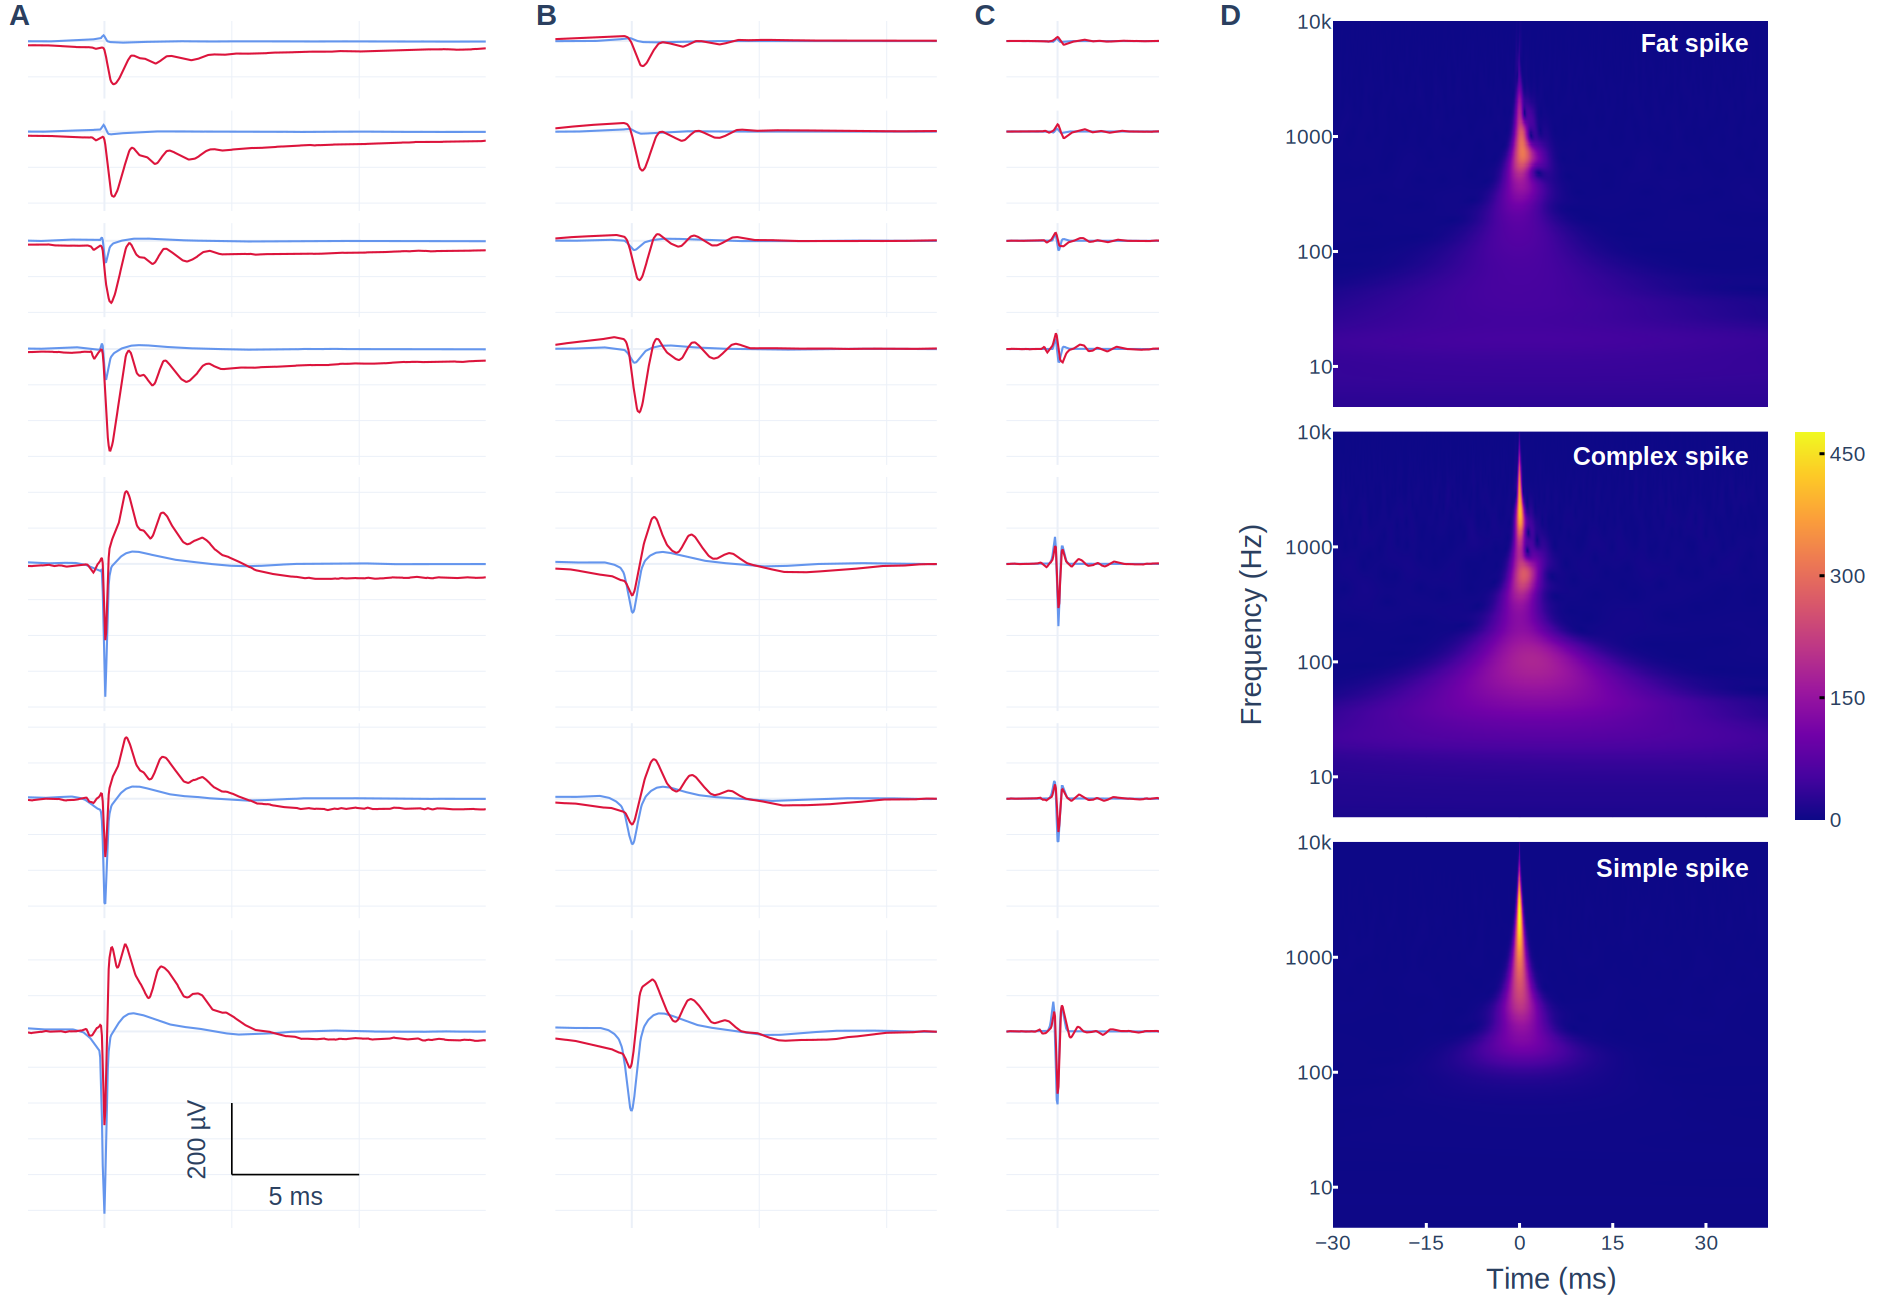

In [14]:
width, height = get_dimensions(max_width_2c, 11.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'legend_font_size': 7*px_per_point,
    'coloraxis': dict(colorscale="Plasma", colorbar=dict(x=1.01, y=0.668, xref="paper", yref="paper", xanchor="left",
                                                         yanchor="top", len=0.338,
                                                         dtick=150, tickfont_size=5*px_per_point, ticks="inside",
                                                         tickcolor="black", tickwidth=0.01*ppi))
}
x_bounds = np.array([[-3, 15], [-3, 12], [-2, 4]])
time_slice = [slice(*nbefore+x_bounds[i]*30) for i in range(3)]
cwt_slice = slice(nbefore-30*30, nbefore+40*30)
cwt_domain = [0.75, 1.0]
cwt_margin_x = 0.10
templates_margin_x = 0.04
templates_margin_y = 0.01
templates_domain_x = np.diff(x_bounds, axis=1) / np.sum(np.diff(x_bounds, axis=1)) * (cwt_domain[0]-cwt_margin_x-2*templates_margin_x)
templates_domain_x = np.c_[[0, templates_margin_x, templates_margin_x], templates_domain_x]
templates_domain_x = np.cumsum(templates_domain_x).reshape(templates_domain_x.shape)
voltage_min = np.min(templates, axis=(0, 1)) - 40
voltage_max = np.max(templates, axis=(0, 1)) + 40
templates_domain_y = np.diff([voltage_min, voltage_max], axis=0) / np.sum(np.diff([voltage_min, voltage_max], axis=0)) * (1-templates_margin_y*(n_channels-1))
templates_domain_y = np.c_[[templates_margin_y]*n_channels, templates_domain_y[0]]
templates_domain_y = np.cumsum(templates_domain_y).reshape(templates_domain_y.shape) - templates_margin_y
templates_domain_y = templates_domain_y.round(5)
                                                                          
for i in range(3):
    layout[f'xaxis{i+1}'] = dict(dtick=5, domain=templates_domain_x[i], showticklabels=False)
for i in range(n_channels):
    layout[f'yaxis{i+1}'] = dict(anchor="x1", range=[voltage_min[i], voltage_max[i]], dtick=100,
                                 domain=templates_domain_y[i], showticklabels=False)
layout['xaxis4'] = dict(title_text="Time (ms)", dtick=15, ticks="inside", tickcolor="white", tickwidth=0.01*ppi,
                        domain=cwt_domain, **axis_format)
for i in range(3):
    layout[f'yaxis{n_channels+i+1}'] = dict(anchor="x4", type="log", dtick=1, ticks="inside", tickcolor="white",
                                            tickwidth=0.01*ppi, domain=[0.34*i, 0.34*(i+1)-0.02], **axis_format)
layout[f'yaxis{n_channels+2}']['title_text'] = "Frequency (Hz)"

fig = go.Figure()
_ = fig.update_layout(**layout)
    
for i in range(n_channels):
    for j in range(2):
        fig.add_trace(go.Scatter(
            xaxis="x1",
            yaxis=f"y{i+1}",
            x=np.arange(*x_bounds[0], 1/30),
            y=templates[j, time_slice[0], i],
            mode="lines",
            marker_color="Cornflowerblue" if j==0 else "Crimson",
            line_width=0.5*px_per_point,
            showlegend=False
        ))
        fig.add_trace(go.Scatter(
            xaxis="x2",
            yaxis=f"y{i+1}",
            x=np.arange(*x_bounds[1], 1/30),
            y=templates_lowFreq[j, time_slice[1], i],
            mode="lines",
            marker_color="Cornflowerblue" if j==0 else "Crimson",
            line_width=0.5*px_per_point,
            showlegend=False
        ))
        fig.add_trace(go.Scatter(
            xaxis="x3",
            yaxis=f"y{i+1}",
            x=np.arange(*x_bounds[2], 1/30),
            y=templates_highFreq[j, time_slice[2], i],
            mode="lines",
            marker_color="Cornflowerblue" if j==0 else "Crimson",
            line_width=0.5*px_per_point,
            showlegend=False
        ))

fig.add_trace(go.Scatter(
    x=[5, 5],
    y=[-400, -200],
    xaxis="x1",
    yaxis="y1",
    mode="lines",
    marker_color="black",
    line_width=0.4*px_per_point,
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[5, 10],
    y=[-400, -400],
    xaxis="x1",
    yaxis="y1",
    mode="lines",
    marker_color="black",
    line_width=0.4*px_per_point,
    showlegend=False
))
fig.add_annotation(x=3.6, y=-300, xref="x1", yref="y1", text="200 µV", textangle=-90, showarrow=False, font_size=6*px_per_point)
fig.add_annotation(x=7.5, y=-460, xref="x1", yref="y1", text="5 ms", showarrow=False, font_size=6*px_per_point)

for i in range(3):
    arr = cwt_SS if i==0 else cwt_CS if i==1 else cwt_FS
    fig.add_trace(go.Heatmap(
        x=np.arange(-30, 40, 1/30),
        y=frequencies,
        z=arr[:, cwt_slice],
        xaxis="x4",
        yaxis=f"y{n_channels+i+1}",
        coloraxis="coloraxis",
        showscale=True
    ))
    text = "Simple" if i==0 else "Complex" if i==1 else "Fat"
    text += " spike"
    fig.add_annotation(x=0.99, y=0.355*(i+1)-0.07, xref="paper", yref="paper", xanchor="right",
                       text=f"<b>{text}</b>", showarrow=False, font_size=6*px_per_point, font_color="white")

for i in range(4):
    x = templates_domain_x[i, 0] if i<3 else (cwt_domain[0] - 0.04)
    fig.add_annotation(x=x-0.012, y=1.02, xref="paper", yref="paper", text=f"<b>{chr(65+i)}</b>", showarrow=False,
                       font_size=7*px_per_point)

fig.show(renderer="svg")
pio.write_image(fig, "figs/spatiotemporal.pdf", width=width, height=height, format="pdf", engine="kaleido")

## Supp: Correlogram window

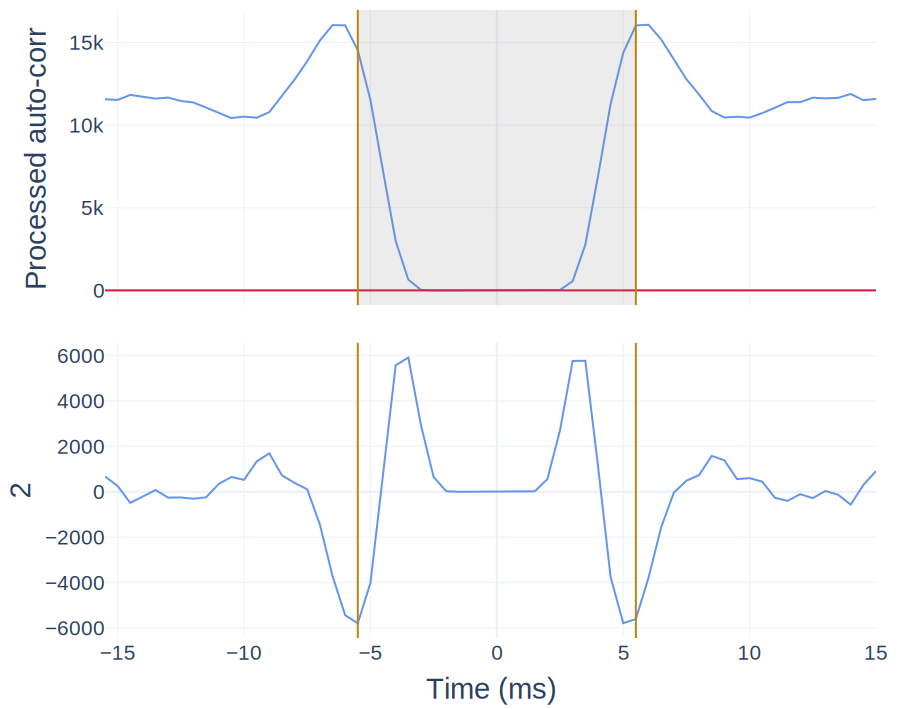

In [15]:
width, height = get_dimensions(max_width_1c, 6.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'showlegend': False,
    'xaxis1': dict(anchor="y1", domain=[0, 1], title_text="Time (ms)", **axis_format),
    'yaxis1': dict(anchor="x1", domain=[0, 0.47], title_text="2<sup>nd</sup> derivative (ms<sup>-2</sup>)", **axis_format),
    'yaxis2': dict(anchor="x1", domain=[0.53, 1], title_text="Processed auto-corr", **axis_format),
}

fig = go.Figure()
fig.update_layout(**layout)

corr_deriv2 = np.gradient(np.gradient(correlograms[0, 0], bins), bins)
fig.add_trace(go.Scatter(
    yaxis="y2",
    x=bins,
    y=correlograms[0, 0],
    mode="lines",
    marker_color="CornflowerBlue"
))
fig.add_trace(go.Scatter(
    yaxis="y1",
    x=bins,
    y=corr_deriv2,
    mode="lines",
    marker_color="CornflowerBlue"
))
fig.add_hline(y=0.5, yref="y2", line_color="Crimson")
w = len(correlograms[0, 0])//2 - scur.auto_merge.get_unit_adaptive_window(correlograms[0, 0], threshold=0.5)
w = bins[w]

fig.add_vrect(x0=-w, x1=w, yref="y2", line_width=0, fillcolor="Gray", opacity=0.15)
for yref in ["y1", "y2"]:
    fig.add_vline(x=w, yref=yref, line_color="DarkGoldenRod")
    fig.add_vline(x=-w, yref=yref, line_color="DarkGoldenRod")

fig.show(renderer="svg")
pio.write_image(fig, "figs/correlogram_window.pdf", width=width, height=height, format="pdf", engine="kaleido")

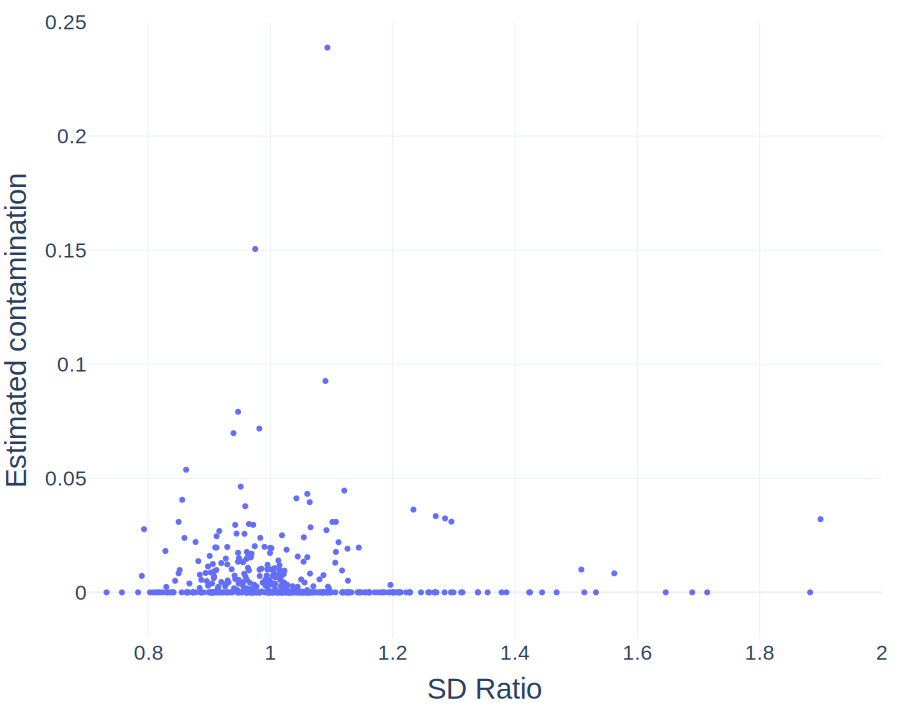

In [16]:
ks_sorting = si.load_extractor("synthetic/analyses/ks2.5_default/processed_sorting")

C = ks_sorting.get_property("estimated_contamination")
sd = ks_sorting.get_property("sd_ratio")

width, height = get_dimensions(max_width_1c, 6.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'showlegend': False,
    'xaxis1': dict(anchor="y1", title_text="SD Ratio", range=[0.7, 2.0], **axis_format),
    'yaxis1': dict(anchor="x1", title_text="Estimated contamination", range=[-0.02, 0.25], **axis_format)
}

fig = go.Figure()
fig.update_layout(**layout)

fig.add_trace(go.Scatter(
    x=sd,
    y=C,
    mode="markers"
))

fig.show(renderer="svg")
pio.write_image(fig, "figs/sd_cont.pdf", width=width, height=height, format="pdf", engine="kaleido")

## Supp: Contamination and SD Ratio

In [ ]:
refractory_periods = {
    'CS': (1.5, 25.0),
    'SS': (0.4, 1.8),
    'Go': (0.4, 2.0),
    'MF': (0.4, 0.9),
    'MLI': (0.4, 0.9),
    'PLI': (0.4, 0.9)
}

estimated_contamination = {'ks': [], 'sc2': [], 'ms3': [], 'lussac': []}
real_contamination = {'ks': [], 'sc2': [], 'ms3': [], 'lussac': []}
sd_ratios = {'ks': [], 'sc2': [], 'ms3': [], 'lussac': []}

for mouse_ID in Path("injection").glob("*/"):
    if mouse_ID.name == "0176":
        continue
        
    recording = si.load_extractor(mouse_ID / "injection" / "recording_injected.bin")
    recording_f = spre.bandpass_filter(recording, ftype="bessel", freq_min=120, freq_max=9000, filter_order=2)
    recording_f = recording_f.save_to_memory()
    gt_sorting = si.load_extractor(mouse_ID / "injection" / "gt_sorting")
    
    utils.Utils.sampling_frequency = recording.sampling_frequency
    utils.Utils.t_max = recording.get_num_frames()
    
    for analysis_name in estimated_contamination.keys():
        sorting_name = "lussac" if analysis_name == "lussac" else \
                       "ks2.5_optimized" if analysis_name == "ks" else \
                       "sc2_default" if analysis_name == "sc2" else \
                       "ms3_SS"
        sorting = si.load_extractor(mouse_ID / "injection" / "analyses" / sorting_name / "sorting")
        comparison = sc.compare_sorter_to_ground_truth(gt_sorting, sorting, match_score=0.33, delta_time=1.0)
        
        tmp_analyzer = si.create_sorting_analyzer(sorting, recording_f, mode="memory", sparse=False)
        tmp_analyzer.compute({
            'random_spikes': {'max_spikes_per_unit': 20_000},
            'templates': {'ms_before': 1.5, 'ms_after': 2.5},
            'spike_amplitudes': {}
        })
        sd_ratio = sqm.compute_sd_ratio(tmp_analyzer)
        
        for neuron_id, unit_id in comparison.best_match_12.items():
            unit_id = int(unit_id)
            if unit_id == -1 or len(sorting.get_unit_spike_train(unit_id)) < 5000:
                continue
            
            cell_type = gt_sorting.get_unit_property(neuron_id, "cell_type")
            refrac_period = refractory_periods[cell_type]
            
            C = utils.estimate_contamination(sorting.get_unit_spike_train(unit_id), refrac_period)
            estimated_contamination[analysis_name].append(C)
            real_contamination[analysis_name].append(1 - comparison.get_performance()['precision'][neuron_id])
            sd_ratios[analysis_name].append(sd_ratio[unit_id])

In [ ]:
def linear_regression(X: np.ndarray, y: np.ndarray) -> tuple[float, float]:
    """
    Performs a linear regression, and returns (coef, intercept, R²).
    """
    
    mask = (X < 0.25) & (y < 0.25)
    X, y = X[mask], y[mask]
    X = X[:, None]
    
    reg = LinearRegression(fit_intercept=True).fit(X, y)
    coef = reg.coef_[0]
    intercept = reg.intercept_
    r2 = reg.score(X, y)
    
    return coef, intercept, r2


colors = {
    'ks': "Crimson",
    'sc2': "Green",
    'ms3': "DarkGoldenRod",
    'lussac': "CornflowerBlue"
}

for var in (estimated_contamination, real_contamination, sd_ratios):
    for key in colors.keys():
        var[key] = np.array(var[key])

width, height = get_dimensions(max_width_sc, 7.9)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10+0.15*ppi, b=10),
    'font_family': "helvetica",
    'showlegend': False,
    'yaxis1': dict(anchor="x1", scaleanchor="x1", title_text="Estimated contamination (%)", range=[-2, 25], domain=[0.58, 1], **axis_format),
    'yaxis2': dict(anchor="x5", scaleanchor="x2", title_text="Estimated contamination (%)", range=[-2, 25], domain=[0, 0.42], **axis_format),
}
for i in range(4):
    layout[f'xaxis{i+1}'] = dict(anchor="y1", title_text="Real contamination (%)", range=[-2, 25],
                                 domain=[i*0.255, i*0.255+0.235], dtick=5, **axis_format)
    layout[f'xaxis{5+i}'] = dict(anchor="y2", title_text="SD Ratio", range=[0.7, 2.0],
                                 domain=[i*0.255, i*0.255+0.235], dtick=0.25, **axis_format)

fig = go.Figure()
fig.update_layout(**layout)

for i, name in enumerate(colors.keys()):
    coef, intercept, r2 = linear_regression(real_contamination[name], estimated_contamination[name])
    fig.add_trace(go.Scatter(
        xaxis=f"x{i+1}",
        yaxis="y1",
        x=[0, 100],
        y=[0, 100*coef],
        mode="lines",
        marker_color="Black",
        line=dict(dash="dash", width=0.005*ppi)
    ))
    fig.add_trace(go.Scatter(
        xaxis=f"x{i+1}",
        yaxis="y1",
        x=100*real_contamination[name],
        y=100*estimated_contamination[name],
        mode="markers",
        marker_color=colors[name]
    ))
    fig.add_annotation(xref=f"x{i+1}", yref="y1", xanchor="left", yanchor="top", x=0.5, y=25, font_size=5*px_per_point,
                      text=f"y = {coef:.3f}x + {intercept:.3f}<br />R² = {r2:.3f}", showarrow=False, align="left",
                      bgcolor="white")
    
    fig.add_trace(go.Scatter(
        xaxis=f"x{5+i}",
        yaxis="y2",
        x=sd_ratios[name],
        y=100*estimated_contamination[name],
        mode="markers",
        marker_color=colors[name]
    ))
    
    text = "Lussac" if name == "lussac" else "Kilosort 2.5" if name == "ks" else "SpyKING CIRCUS 2" if name == "sc2" else "MountainSort 3"
    fig.add_annotation(xref=f"x{'' if i==0 else i+1} domain", yref="paper", xanchor="center", yanchor="bottom",
                       x=0.5, y=1.02, text=f"<b>{text}</b>", font_size=7*px_per_point, showarrow=False)

fig.show(renderer="svg")
pio.write_image(fig, "figs/contamination.pdf", width=width, height=height, format="pdf", engine="kaleido")

## Supp: Merged units

In [ ]:
gt_recording = si.load_extractor("synthetic/recording_filtered.bin")
gt_sorting = si.load_extractor("synthetic/analyses/ground_truth/sorting")
ks_sorting = si.load_extractor("synthetic/analyses/ks2.5_default/processed_sorting")
lussac_sorting = si.load_extractor("synthetic/analyses/lussac_heavy/processed_sorting")

ks_analyzer = si.create_sorting_analyzer(ks_sorting, gt_recording, format="memory", sparse=False, return_scaled=True)
gt_analyzer = si.create_sorting_analyzer(gt_sorting, gt_recording, format="memory", sparse=False, return_scaled=True)

unit_indices = np.where(ks_sorting.get_property("gt_label") == "Merged")[0]
unit_ids = ks_sorting.unit_ids[unit_indices]
C = sqm.compute_refrac_period_violations(ks_analyzer, refractory_period_ms=1.9, unit_ids=unit_ids)[0]
print(C)

n_spikes = ks_sorting.count_num_spikes_per_unit(outputs="array")
n_true_spikes = gt_sorting.count_num_spikes_per_unit(outputs="array")
n_lussac_spikes = lussac_sorting.count_num_spikes_per_unit(outputs="array")

tp = np.load("/mnt/hdd/tmp/lussac_benchmark/synthetic/coincidence_matrices/ks2.5_default_with_ground_truth.npy")
fn = n_true_spikes[None, :] - tp
fp = n_spikes[:, None] - tp

agreement_matrix = tp / (tp + fp + fn)
precision_matrix = tp / (tp + fp)
recall_matrix = tp / (tp + fn)

lussac_tp = np.load("/mnt/hdd/tmp/lussac_benchmark/synthetic/coincidence_matrices/lussac_heavy_with_ground_truth.npy")
lussac_fn = n_true_spikes[None, :] - lussac_tp
lussac_fp = n_lussac_spikes[:, None] - lussac_tp
lussac_agreement_matrix = lussac_tp / (lussac_tp + lussac_fp + lussac_fn)
lussac_precision_matrix = lussac_tp / (lussac_tp + lussac_fp)

for unit_index, unit_id in zip(unit_indices, unit_ids):
    recall = np.sort(recall_matrix[unit_index, :])[::-1]
    print(unit_id, (100*recall).round(1)[:4])

In [ ]:
# unit_ids = np.array([316, 281, 352, 269])
unit_ids = np.array([316, 281, 269])

ks_analyzer = ks_analyzer.select_units(unit_ids)
ks_analyzer.compute({
    'random_spikes': {'max_spikes_per_unit': 20_000},
    'templates': {'ms_before': 1.5, 'ms_after': 2.5},
    'spike_amplitudes': {},
    'correlograms': {'window_ms': 24.5, 'bin_ms': 0.25}
})
sd_ratio = sqm.compute_sd_ratio(ks_analyzer)
gt_analyzer.compute({
    'random_spikes': {'max_spikes_per_unit': 20_000},
    'templates': {'ms_before': 1.5, 'ms_after': 2.5}
})

correlograms = ks_analyzer.get_extension("correlograms").get_data()[0]
corr_bins = ks_analyzer.get_extension("correlograms").get_data()[1]
bin_size = corr_bins[1] - corr_bins[0]

templates_ext = ks_analyzer.get_extension("templates")
templates = templates_ext.get_data()
t_axis = np.arange(-templates_ext.nbefore, templates_ext.nafter) / 30

In [ ]:
n_units = len(unit_ids)
y_spacing = 0.05
row_height = (1 - y_spacing*(n_units-1)) / n_units

width, height = get_dimensions(max_width_2c, 11.0)
layout = {
    'width': width,
    'height': height,
    'template': "plotly_white",
    'margin': dict(l=10, r=10, t=10, b=10),
    'font_family': "helvetica",
    'xaxis1': dict(anchor="y5", domain=[0, 0.36], title_text="Time (ms)", **axis_format),
    'xaxis2': dict(anchor="y6", domain=[0.44, 0.56], **axis_format),
    'xaxis3': dict(anchor="y6", domain=[0.58, 0.70], title_text="Time (ms)", **axis_format),
    'xaxis4': dict(anchor="y6", domain=[0.72, 0.84], **axis_format),
    'xaxis5': dict(domain=[0.9, 1], **axis_format)
}

for i in range(n_units):
    top = round(1 - i*(row_height+y_spacing), 5)
    layout[f'yaxis{2*i+1}'] = dict(anchor="x1", domain=[top-row_height, top], **axis_format)
    layout[f'yaxis{2*i+2}'] = dict(anchor="x2", domain=[top-row_height, top], title_text="Voltage (µV)", **axis_format)

fig = go.Figure()

for i, unit_id in zip(range(n_units), unit_ids):
    unit_index = ks_sorting.id_to_index(unit_id)
    neuron_indices = np.where(recall_matrix[unit_index] > 1/3)[0]
    neuron_ids = gt_sorting.unit_ids[neuron_indices]
    neuron_colors = ["HotPink", "Gold", "PaleGreen"][:len(neuron_ids)]
    
    print(f"Unit {unit_id} is a merge of {neuron_ids}")
    for neuron_id in neuron_ids:
        neuron_index = gt_sorting.id_to_index(neuron_id)
        print(f"\t- Lussac recovered neuron {neuron_id} with precision {np.max(lussac_precision_matrix[:, neuron_index]):.1%}")
    
    fig.add_trace(go.Bar(
        xaxis=f"x1", yaxis=f"y{2*i+1}",
        x=corr_bins[:-1] + bin_size/2,
        y=correlograms[i, i],
        width=bin_size,
        marker_color="CornflowerBlue",
        showlegend=False
    ))
    fig.add_annotation(text=f"C = {C[unit_id]:.1%}", xref="x domain", yref=f"y{2*i+1 if i>0 else ''} domain",
                       xanchor="right", yanchor="bottom", x=0.95, y=0.94, showarrow=False, font_size=6*px_per_point)
    
    best_channels = np.argsort(np.max(np.abs(templates[i]), axis=0))[::-1]
    for j in range(3):
        for k in range(len(neuron_ids)-1, -1, -1):
            fig.add_trace(go.Scatter(
                xaxis=f"x{j+2}",
                yaxis=f"y{2*i+2}",
                x=t_axis,
                y=gt_analyzer.get_extension("templates").get_data()[neuron_indices[k], :, best_channels[j]],
                mode="lines",
                marker_color=neuron_colors[k],
                showlegend=False
            ))
        fig.add_trace(go.Scatter(
            xaxis=f"x{j+2}",
            yaxis=f"y{2*i+2}",
            x=t_axis,
            y=templates[i, :, best_channels[j]],
            mode="lines",
            marker_color="CornflowerBlue",
            showlegend=False
        ))
    fig.add_annotation(text=f"SDR = {sd_ratio[unit_id]:.2f}", xref="paper", yref=f"y{2*i+2} domain",
                       xanchor="center", yanchor="bottom", x=0.57, y=0.05, showarrow=False, font_size=6*px_per_point)
    
    pie_chart = {neuron_id: precision_matrix[unit_index, neuron_index] for neuron_id, neuron_index in zip(neuron_ids, neuron_indices)}
    pie_chart['Other'] = 1 - sum(pie_chart.values())
    fig.add_trace(go.Pie(
        labels=list(pie_chart.keys()),
        values=list(pie_chart.values()),
        textinfo="label+percent",
        showlegend=False,
        domain=dict(x=layout['xaxis5']['domain'], y=layout[f'yaxis{2*i+1}']['domain']),
        textfont_size=5*px_per_point,
        marker_colors=neuron_colors + ["Black"]
    ))

x_pos = [-0.02, 0.388, 0.86]
for i in range(3):
    fig.add_annotation(
        text=f"<b>{chr(65+i)}</b>",
        xref="paper",
        yref=f"paper",
        xanchor="left",
        yanchor="bottom",
        x=x_pos[i],
        y=1.01,
        showarrow=False,
        font=dict(size=7*px_per_point)
    )

fig.update_layout(**layout)

fig.show(renderer="svg")
pio.write_image(fig, "figs/merged_units.pdf", width=width, height=height, format="pdf", engine="kaleido")